# Python Library installs and typical imports

## pip installs
Please use an A100 to run this Notebook in Colab.  😞

This is due to the sentence transformer embeddings.  Colab for some reason is still much slower than if I run this on a Mac M3.

In [1]:
!pip install sentence-transformers
!pip install scikit-learn
!pip install textstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## Common Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
import scipy.stats as stats
import textstat
import sklearn
import json
import glob
import warnings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
import re
import unicodedata

# Data Import

## Data Location

In [3]:

# Comment out if you just aren't going to use Drive and upload the fles to Colab
drive.mount('/content/drive')
dir = 'drive/MyDrive/colab_data/'

# Or...... for accessing it locally upload the grofsky_data file to the Colab root data dir
# dir = ''



Mounted at /content/drive


## Load Rubric and Tool Threats

Load Rubric extraction data and Tool batch run threat results.

In [4]:
# Load the csv file in /grofsky_data/rubric_scores.csv
rubric_df = pd.read_csv(f'{dir}grofsky_data/rubric_scores.csv')

# Find all JSON files matching the pattern
result_files = glob.glob(f'{dir}grofsky_data/tool_results_med/Case-Study-*-results.json')

# List to store the parsed data
data_for_threat_df = []


# Function to convert non-printable and escape sequences to their text equivalent
def normalize_text(text):
    # If text is not a string, return it as is
    if not isinstance(text, str):
        return text

    # Normalize the text to NFKD form, which will decompose characters with accents, etc.
    # For some reason ChatGPT likes to output unicode :thinking_face:
    normalized_text = unicodedata.normalize('NFKD', text)

    # Convert non-breaking space (\u00a0) to a normal space
    normalized_text = normalized_text.replace('\u00a0', ' ')

    # Optional: Additional conversion for specific characters (e.g., fancy quotes to regular quotes)
    normalized_text = re.sub(r'[“”]', '"', normalized_text)  # Convert fancy quotes to straight quotes
    normalized_text = re.sub(r"[‘’]", "'", normalized_text)  # Convert fancy single quotes to straight quotes

    # Return normalized text
    return normalized_text

# Loop through the result files
for result_file in result_files:
    # Extract the case study number (x) from the filename
    x = result_file.split('-')[2]

    # Skip invalid files where x is not a number
    if not x.isdigit():
        print(f"Skipping invalid case study file: {result_file}")
        continue

    print(f"Processing Case Study {x}")

    try:
        # Open and load the JSON file
        with open(result_file, 'r') as f:
            results_data = json.load(f)

        # Validate the JSON format
        if not isinstance(results_data, list):
            print(f"Invalid format in file: {result_file}")
            continue

        # Extract relevant data from the JSON and store it
        for entry in results_data:
            case_number = entry.get("case_number", "Unknown")
            batch_number = entry.get("batch_number", "Unknown")
            for threat in entry.get("threats", []):
                threat_type = normalize_text(threat.get("Threat Type", ""))
                scenario = normalize_text(threat.get("Scenario", ""))
                impact = normalize_text(threat.get("Potential Impact", ""))
                mitre_technique = normalize_text(threat.get("mitre_technique", {}).get("name", ""))
                pa_id = normalize_text(threat.get("mitre_technique", {}).get("id", ""))
                t_id = normalize_text(threat.get("mitre_technique", {}).get("technique_id", ""))


                # Add this data to the list for the dataframe
                data_for_threat_df.append({
                    "Case Study Number": case_number,
                    "Batch Number": batch_number,
                    "Threat Type": threat_type,
                    "Scenario": scenario,
                    "Potential Impact": impact,
                    "MITRE Technique": mitre_technique,
                    "MITRE PA-ID": pa_id,
                    "MITRE TID": t_id
                })

    except json.JSONDecodeError as e:
        print(f"Error parsing JSON in file {result_file}: {e}")

# Create a DataFrame from the data
tool_results_df = pd.DataFrame(data_for_threat_df)

# Display the DataFrame for sanity
tool_results_df.head()

Processing Case Study 1
Processing Case Study 2
Processing Case Study 3
Processing Case Study 4
Processing Case Study 10
Processing Case Study 11
Processing Case Study 12
Processing Case Study 13
Processing Case Study 14
Processing Case Study 15
Processing Case Study 5
Processing Case Study 6
Processing Case Study 7
Processing Case Study 8
Processing Case Study 9


,Case Study Number,Batch Number,Threat Type,Scenario,Potential Impact,MITRE Technique,MITRE PA-ID,MITRE TID
0,1,1,Spoofing,An attacker uses voice imitation software to i...,"Unauthorized access to the system, which can l...",Unknown,attack-pattern--00000000-0000-0000-0000-000000...,N/A
1,1,1,Spoofing,An attacker gains access to the client-side ap...,Access to sensitive data and unauthorized cont...,Unknown,attack-pattern--00000000-0000-0000-0000-000000...,N/A
2,1,1,Spoofing,An attacker uses a compromised IoT controller ...,"Execution of unauthorized actions, leading to ...",Unknown,attack-pattern--00000000-0000-0000-0000-000000...,N/A
3,1,1,Tampering,An attacker modifies the firmware on IoT devic...,"Altered device behavior, compromising data int...",Unknown,attack-pattern--00000000-0000-0000-0000-000000...,N/A
4,1,1,Tampering,Malicious actors intercept and modify voice co...,"Execution of unauthorized or harmful actions, ...",Unknown,attack-pattern--00000000-0000-0000-0000-000000...,N/A


## Load Case Study Threats

Load Case Study threat extraction results

In [5]:
# Find all JSON files matching the pattern
result_files = glob.glob(f'{dir}grofsky_data/case_results/Case-Study-*-Extracted.json')

# List to store the parsed data
data_for_threat_df = []

# Loop through the result files
for result_file in result_files:
    # Extract the case study number (x) from the filename
    x = result_file.split('-')[2]

    # Skip invalid files where x is not a number (this should never happen)
    if not x.isdigit():
        print(f"Skipping invalid case study file: {result_file}")
        continue

    print(f"Processing Case Study {x}")

    try:
        # Open and load the JSON file
        with open(result_file, 'r') as f:
            results_data = json.load(f)

        # Validate the JSON format
        if not isinstance(results_data, list):
            print(f"Invalid format in file: {result_file}")
            continue

        # Extract relevant data from the JSON and store it
        for entry in results_data:
            threat_type = entry.get("Threat Type", "")
            scenario = entry.get("Scenario", "")

            # Add this data to the list for the dataframe
            data_for_threat_df.append({
                "Case Study Number": x,
                "Threat Type": threat_type,
                "Scenario": scenario,
            })

    except json.JSONDecodeError as e:
        print(f"Error parsing JSON in file {result_file}: {e}")

# Create a DataFrame from the data
case_results_df = pd.DataFrame(data_for_threat_df)

# Display the DataFrame again fro sanity
case_results_df.head()

Processing Case Study 3
Processing Case Study 4
Processing Case Study 6
Processing Case Study 7
Processing Case Study 8
Processing Case Study 10
Processing Case Study 11
Processing Case Study 1
Processing Case Study 2
Processing Case Study 5
Processing Case Study 9
Processing Case Study 12
Processing Case Study 13
Processing Case Study 14
Processing Case Study 15


,Case Study Number,Threat Type,Scenario
0,3,Spoofing,A rogue node could be placed physically out of...
1,3,Spoofing,The NSMF is a critical component of 5G. It is ...
2,3,Spoofing,The UE uses NSSAI to select a network slice. I...
3,3,Spoofing,One of the risks associated with untrusted har...
4,3,Spoofing,Successful impersonation of the SMF can give t...


In [6]:
# Make sure everything is cool

rubric_df.info()
tool_results_df.info()
case_results_df.info()

tool_results_df.to_csv('tool_threats.csv', index=False)
case_results_df.to_csv('paper_threats.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Case Study                             15 non-null     object
 1   Case Study Number                      15 non-null     int64 
 2   Application/System Description or DFD  15 non-null     int64 
 3   Application Type                       15 non-null     int64 
 4   Industry Sector                        15 non-null     int64 
 5   Data Sensitivity                       15 non-null     int64 
 6   Internet Facing                        15 non-null     int64 
 7   Compliance Requirements                15 non-null     int64 
 8   Authentication Methods                 15 non-null     int64 
 9   Technical Details                      15 non-null     int64 
 10  Threat Details                         15 non-null     int64 
 11  Threat Count         

# Exploratory Data Analysis: Threats

## Normality Tests & Graphs


1. **Scenario Word Count Distribution**:
   - **Tool Results**: The tool-generated results show a concentrated distribution, primarily around 10-15 words per scenario. **Great for standardization and automation, while still being tailored to the domain**.
   - **Case Results**: Case studies exhibit broader variability, showing that **experts provide more tailored and complex scenarios**, but this isn’t necessarily more effective than the tool.

2. **KDE Plot of Word Count by Threat Type for Tool Results**:
   - The tool's KDE shows consistent word counts across `Threat Types`, peaking at 10-15 words. **Ideal for ensuring uniform threat descriptions** while incorporating specific domain context.

3. **KDE Plot of Word Count by Threat Type for Case Results (Third Plot)**:
   - The case results display wide variations in word count, especially for complex threats like **Elevation of Privilege**, suggesting that **experts adjust complexity based on context**—but the tool adapts to domain context as well.

4. **Scenario Word Count per Threat Type**:
   - The tool-generated word counts are shorter and more uniform, while case study results have higher word counts. **The tool produces concise, efficient, and domain-relevant scenarios**.

5. **Word Cloud for Tool Results**:
   - Frequent terms like "attacker" and "vulnerability" reflect that the tool **captures key security concerns, dynamically adjusted based on the domain**.
   
6. **Word Cloud for Case Results**:
   - Case results show domain-specific terms like "device" and "network," but **the tool also integrates this context when generating threats**.

7. **Scenario Word Count Distribution by Threat Type**:
   - **Tool Results**: Narrow distributions across all `Threat Types`, highlighting the tool’s **consistent output within the domain context**.
   - **Case Results**: Greater variability, indicating **expert flexibility**, though the tool tailors its output to domain-specific requirements as well.

8. **Radar Chart: Average Word Count by Threat Type**:
   - The tool maintains lower average word counts, showcasing its **efficiency and ability to generate domain-specific threats concisely**, while case studies often produce more detailed, but less consistent, scenarios.

---

### **Normality Test Results**:

#### **Tool Results**:
- Small p-values across all threat types indicate non-normality.
- This suggests that the tool's outputs do not follow a normal distribution, which is expected for automated generation across diverse scenarios.
- The non-normality reflects the tool's versatility in generating threats tailored to various domains, as it dynamically adjusts outputs instead of sticking to a uniform pattern.

#### **Case Results**:
- Some threat types (like Spoofing) exhibit normality based on higher p-values, suggesting that expert-derived threats may follow more standard patterns in specific domains.
- Most other threat types show non-normality, which aligns with the expert-driven nature of case studies where customization and context-specific considerations are prominent.
- This highlights how the tool complements expert models by dynamically producing domain-appropriate results even when the expert approach leads to more irregular threat distributions.



Occurrences of 'attacker': 4446


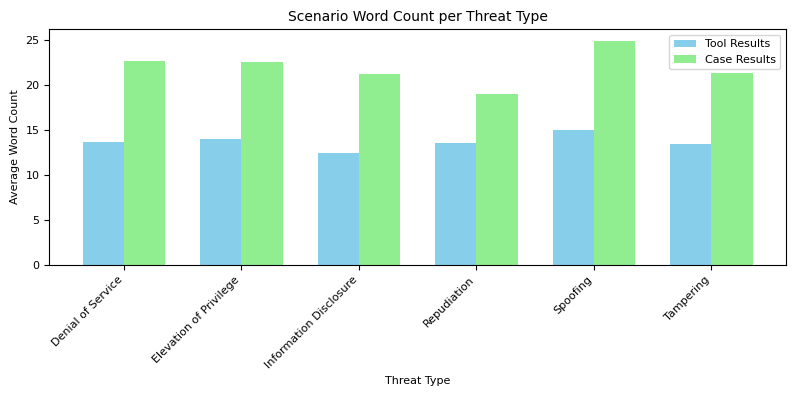

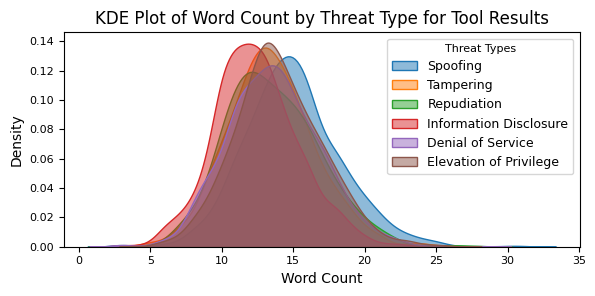

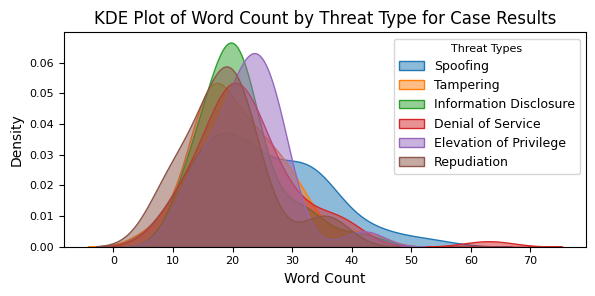

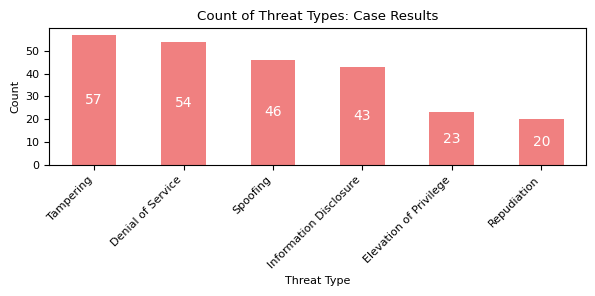

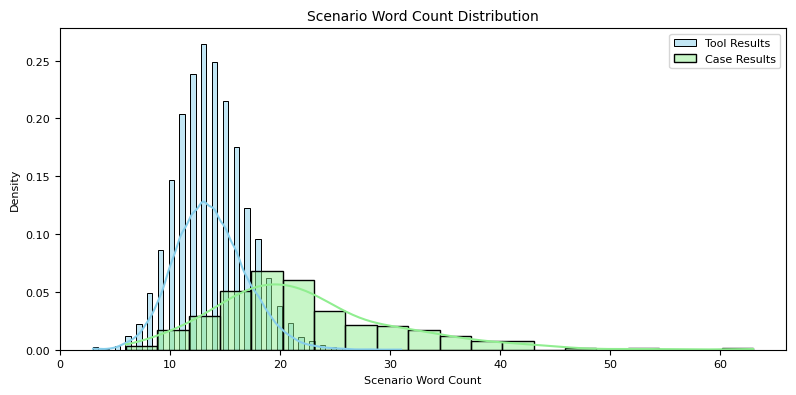

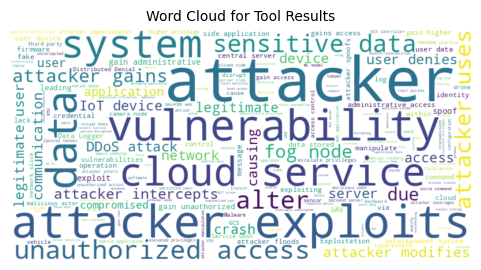

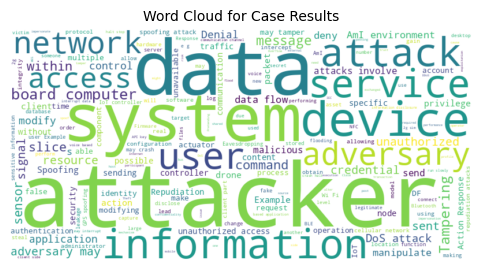

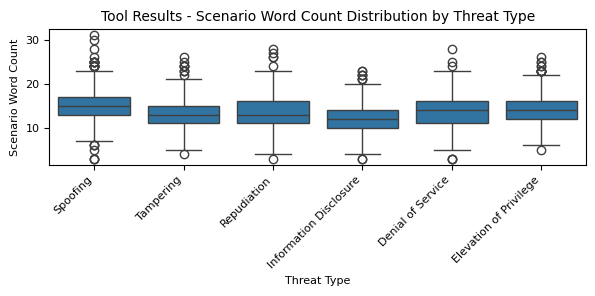

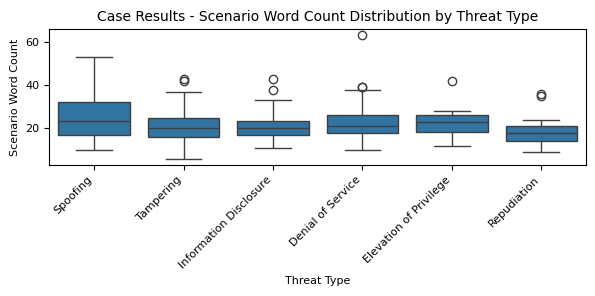

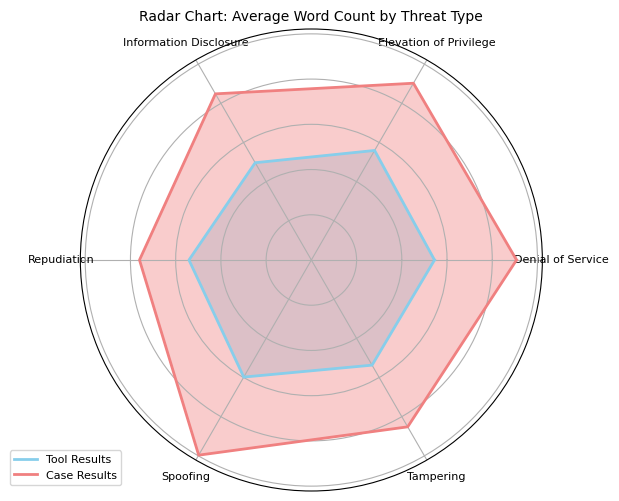

Normality Test Results for Tool Results


,Shapiro-Wilk p-value,K-S p-value
Spoofing,3.114749e-12,1.197445e-11
Tampering,1.468786e-10,3.110788e-09
Repudiation,7.956007e-12,2.251715e-10
Information Disclosure,2.618690e-11,3.171659e-11
Denial of Service,4.619874e-09,6.840470e-08
Elevation of Privilege,1.093179e-10,1.030297e-11


Normality Test Results for Case Results


,Shapiro-Wilk p-value,K-S p-value
Spoofing,0.060394,0.649707
Tampering,0.032203,0.108860
Information Disclosure,0.002896,0.222879
Denial of Service,0.000016,0.091632
Elevation of Privilege,0.069779,0.570394
Repudiation,0.035325,0.741180


Density plot data saved to 'density_plot_data.csv'.


In [7]:
from math import pi
from scipy import stats

# Set the font size globally - I still don't understand why this doesn't work in some instances.  :(
plt.rcParams.update({'font.size': 8})

# Word Count
def plot_combined_scenario_word_count(df1, df2, df1_title, df2_title):
    # Calculate word count in each scenario for both dataframes
    df1['Scenario Word Count'] = df1['Scenario'].apply(lambda x: len(str(x).split()))
    df2['Scenario Word Count'] = df2['Scenario'].apply(lambda x: len(str(x).split()))

    # Group by Threat Type and calculate mean word count for both dataframes
    df1_word_count_per_threat = df1.groupby('Threat Type')['Scenario Word Count'].mean()
    df2_word_count_per_threat = df2.groupby('Threat Type')['Scenario Word Count'].mean()

    # Align indexes for comparison (in case one Threat Type is missing in one of the dataframes)
    combined_df = pd.concat([df1_word_count_per_threat, df2_word_count_per_threat], axis=1).fillna(0)
    combined_df.columns = [df1_title, df2_title]

    # Plotting
    plt.figure(figsize=(8, 4))
    bar_width = 0.35
    index = np.arange(len(combined_df))

    # Create the bars side by side
    plt.bar(index, combined_df[df1_title], bar_width, label=df1_title, color='skyblue')
    plt.bar(index + bar_width, combined_df[df2_title], bar_width, label=df2_title, color='lightgreen')

    plt.xlabel('Threat Type', fontsize=8)
    plt.ylabel('Average Word Count', fontsize=8)
    plt.title('Scenario Word Count per Threat Type', fontsize=10)
    plt.xticks(index + bar_width / 2, combined_df.index, rotation=45, ha='right', fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend()

    plt.tight_layout()
    plt.show()



# Function to plot count of threat types with values displayed inside the bars
def plot_threat_type_count(df, title):
    # Count occurrences of each threat type
    threat_type_count = df['Threat Type'].value_counts()

    plt.figure(figsize=(6,3))
    ax = threat_type_count.plot(kind='bar', color='lightcoral')
    plt.title(f'Count of Threat Types: {title}')
    plt.xlabel('Threat Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')

    # Annotate the bars with their values inside the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2., p.get_height() / 2),  # Center the label inside the bar
                    ha='center', va='center', fontsize=10, color='white')  # Adjust color to stand out

    plt.tight_layout()
    plt.show()




def plot_word_count_distribution(df1, df2, df1_title, df2_title):
    # Calculate word count in each scenario
    df1['Scenario Word Count'] = df1['Scenario'].apply(lambda x: len(str(x).split()))
    df2['Scenario Word Count'] = df2['Scenario'].apply(lambda x: len(str(x).split()))


    plt.figure(figsize=(8, 4))

    # Histogram for tool_results_df
    sns.histplot(df1['Scenario Word Count'], kde=True, color='skyblue', label=df1_title, stat='density')

    # Histogram for case_results_df
    sns.histplot(df2['Scenario Word Count'], kde=True, color='lightgreen', label=df2_title, stat='density')


    plt.title('Scenario Word Count Distribution', fontsize=10)
    plt.xlabel('Scenario Word Count', fontsize=8)
    plt.ylabel('Density', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend()

    plt.tight_layout()
    plt.show()


from wordcloud import WordCloud

def plot_wordcloud(df, title):
    # Combine all scenarios into a single string
    text = ' '.join(df['Scenario'].astype(str).tolist())

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)


    plt.figure(figsize=(6,3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {title}', fontsize=10)
    plt.show()

from collections import Counter

def inspect_text(df):
    # Combine all scenarios into a single string
    text = ' '.join(df['Scenario'].astype(str).tolist())

    # Normalize text: convert to lowercase and remove special characters
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)  # Remove special characters

    # Split the text into individual words
    words = text.split()

    # Count the occurrences of each word
    word_counts = Counter(words)

    # Print occurrences of "attacker" and other words
    print(f"Occurrences of 'attacker': {word_counts['attacker']}")
    return word_counts

# Run this before plotting the word cloud to inspect the word counts
inspect_text(tool_results_df)






def plot_scenario_word_count_boxplot(df, title):
    # Calculate word count in each scenario
    df['Scenario Word Count'] = df['Scenario'].apply(lambda x: len(str(x).split()))


    plt.figure(figsize=(6,3))
    sns.boxplot(x='Threat Type', y='Scenario Word Count', data=df)
    plt.title(f'{title} - Scenario Word Count Distribution by Threat Type', fontsize=10)
    plt.xlabel('Threat Type', fontsize=8)
    plt.ylabel('Scenario Word Count', fontsize=8)
    plt.xticks(rotation=45, ha='right', fontsize=8)

    plt.tight_layout()
    plt.show()



def plot_radar_chart_word_count(df1, df2, df1_title, df2_title):
    # Calculate word count in each scenario
    df1['Scenario Word Count'] = df1['Scenario'].apply(lambda x: len(str(x).split()))
    df2['Scenario Word Count'] = df2['Scenario'].apply(lambda x: len(str(x).split()))

    # Group by Threat Type and calculate mean word count
    df1_word_count_per_threat = df1.groupby('Threat Type')['Scenario Word Count'].mean()
    df2_word_count_per_threat = df2.groupby('Threat Type')['Scenario Word Count'].mean()

    # Combine the data and ensure matching indexes
    combined_df = pd.concat([df1_word_count_per_threat, df2_word_count_per_threat], axis=1).fillna(0)
    combined_df.columns = [df1_title, df2_title]

    # Number of variables we're plotting (Threat Types)
    categories = list(combined_df.index)
    num_vars = len(categories)

    # Set up angles for radar chart - hmmm
    angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
    angles += angles[:1]  # Close the circle

    # Initialize the radar chart
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Radar plot for tool_results_df
    values = combined_df[df1_title].values.flatten().tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, color='skyblue', linewidth=2, linestyle='solid', label=df1_title)
    ax.fill(angles, values, color='skyblue', alpha=0.4)

    # Radar plot for case_results_df
    values = combined_df[df2_title].values.flatten().tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, color='lightcoral', linewidth=2, linestyle='solid', label=df2_title)
    ax.fill(angles, values, color='lightcoral', alpha=0.4)

    # Add labels for each angle (Threat Types)
    ax.set_yticklabels([])  # Hide radial labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=8)


    plt.title('Radar Chart: Average Word Count by Threat Type', fontsize=10)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

    plt.show()

def plot_combined_kde_word_count(df, title):
    # Calculate word count in each scenario
    df['Scenario Word Count'] = df['Scenario'].apply(lambda x: len(str(x).split()))

    # Plot KDE for each Threat Type on the same plot
    plt.figure(figsize=(6, 3))

    # Iterate through unique threat types and plot their KDE and magic happens
    for threat_type in df['Threat Type'].unique():
        sns.kdeplot(df[df['Threat Type'] == threat_type]['Scenario Word Count'],
                    label=threat_type, fill=True, alpha=0.5)


    plt.title(f'KDE Plot of Word Count by Threat Type for {title}', fontsize=12)
    plt.xlabel('Word Count', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend(title="Threat Types", fontsize=9)

    plt.tight_layout()
    plt.show()


# Plot Combined Scenario Word Count by Threat Type
plot_combined_scenario_word_count(tool_results_df, case_results_df, 'Tool Results', 'Case Results')
print("\n" * 3)

# KDE of Scenario Word Count by Threat Type for Tool and Cases
plot_combined_kde_word_count(tool_results_df, 'Tool Results')
print("\n" * 3)
plot_combined_kde_word_count(case_results_df, 'Case Results')
print("\n" * 3)

#Plot Count of Case Threat Types
plot_threat_type_count(case_results_df, 'Case Results')
print("\n" * 3)

# Plot ScenarioWord Count Distribution by Tool and Cases
plot_word_count_distribution(tool_results_df, case_results_df, 'Tool Results', 'Case Results')
print("\n" * 3)

# Plot a Tool Result WordCloud
plot_wordcloud(tool_results_df, 'Tool Results')
print("\n" * 3)

# Plot a Case Result Word Cloud
plot_wordcloud(case_results_df, 'Case Results')
print("\n" * 3)

# Plot a Scenario Word Count Boxplot for Tool Results
plot_scenario_word_count_boxplot(tool_results_df, 'Tool Results')
print("\n" * 3)

# Plot a Scenario Word Count Boxplot for Case Results
plot_scenario_word_count_boxplot(case_results_df, 'Case Results')
print("\n" * 3)

# Radar Chart of Scenario Word Counts by Threat Types for Tool and Cases
plot_radar_chart_word_count(tool_results_df, case_results_df, 'Tool Results', 'Case Results')

# That seemed to be the easiest way to set it up
# Normality checks below just to see what I'm dealing with here


def check_normality(df, df_title):
    # Calculate word count in each scenario
    df['Scenario Word Count'] = df['Scenario'].apply(lambda x: len(str(x).split()))

    # Initialize dictionary to store results
    normality_results = {}

    # Iterate through each unique Threat Type
    for threat_type in df['Threat Type'].unique():
        word_counts = df[df['Threat Type'] == threat_type]['Scenario Word Count']

        # Both tests are used to assess normality, with Shapiro-Wilk being more powerful for small samples, and K-S providing flexibility in comparing against a specified distribution.

        # Shapiro-Wilk test
        shapiro_test = stats.shapiro(word_counts)

        # Kolmogorov-Smirnov test against normal distribution
        ks_test = stats.kstest(word_counts, 'norm', args=(word_counts.mean(), word_counts.std()))

        # Store results for both tests
        normality_results[threat_type] = {
            'Shapiro-Wilk p-value': shapiro_test.pvalue,
            'K-S p-value': ks_test.pvalue
        }

    # Convert results to DataFrame for readability
    normality_df = pd.DataFrame(normality_results).T
    normality_df.columns = ['Shapiro-Wilk p-value', 'K-S p-value']

    # Print the results
    print(f'Normality Test Results for {df_title}')
    display(normality_df)

# Call the function for both DataFrames
check_normality(tool_results_df, 'Tool Results')
check_normality(case_results_df, 'Case Results')

# Save the exact data used for the density plot
density_data = pd.DataFrame({
    'Tool Word Counts': tool_results_df['Scenario Word Count'].reset_index(drop=True),
    'Paper Word Counts': case_results_df['Scenario Word Count'].reset_index(drop=True)
})

# Save to CSV
density_data.to_csv('density_plot_data.csv', index=False)

print("Density plot data saved to 'density_plot_data.csv'.")



## Exploratory Data Analysis: Case Study Rubric

Highlighting the variation in the extraction data based on the rubric scoring.

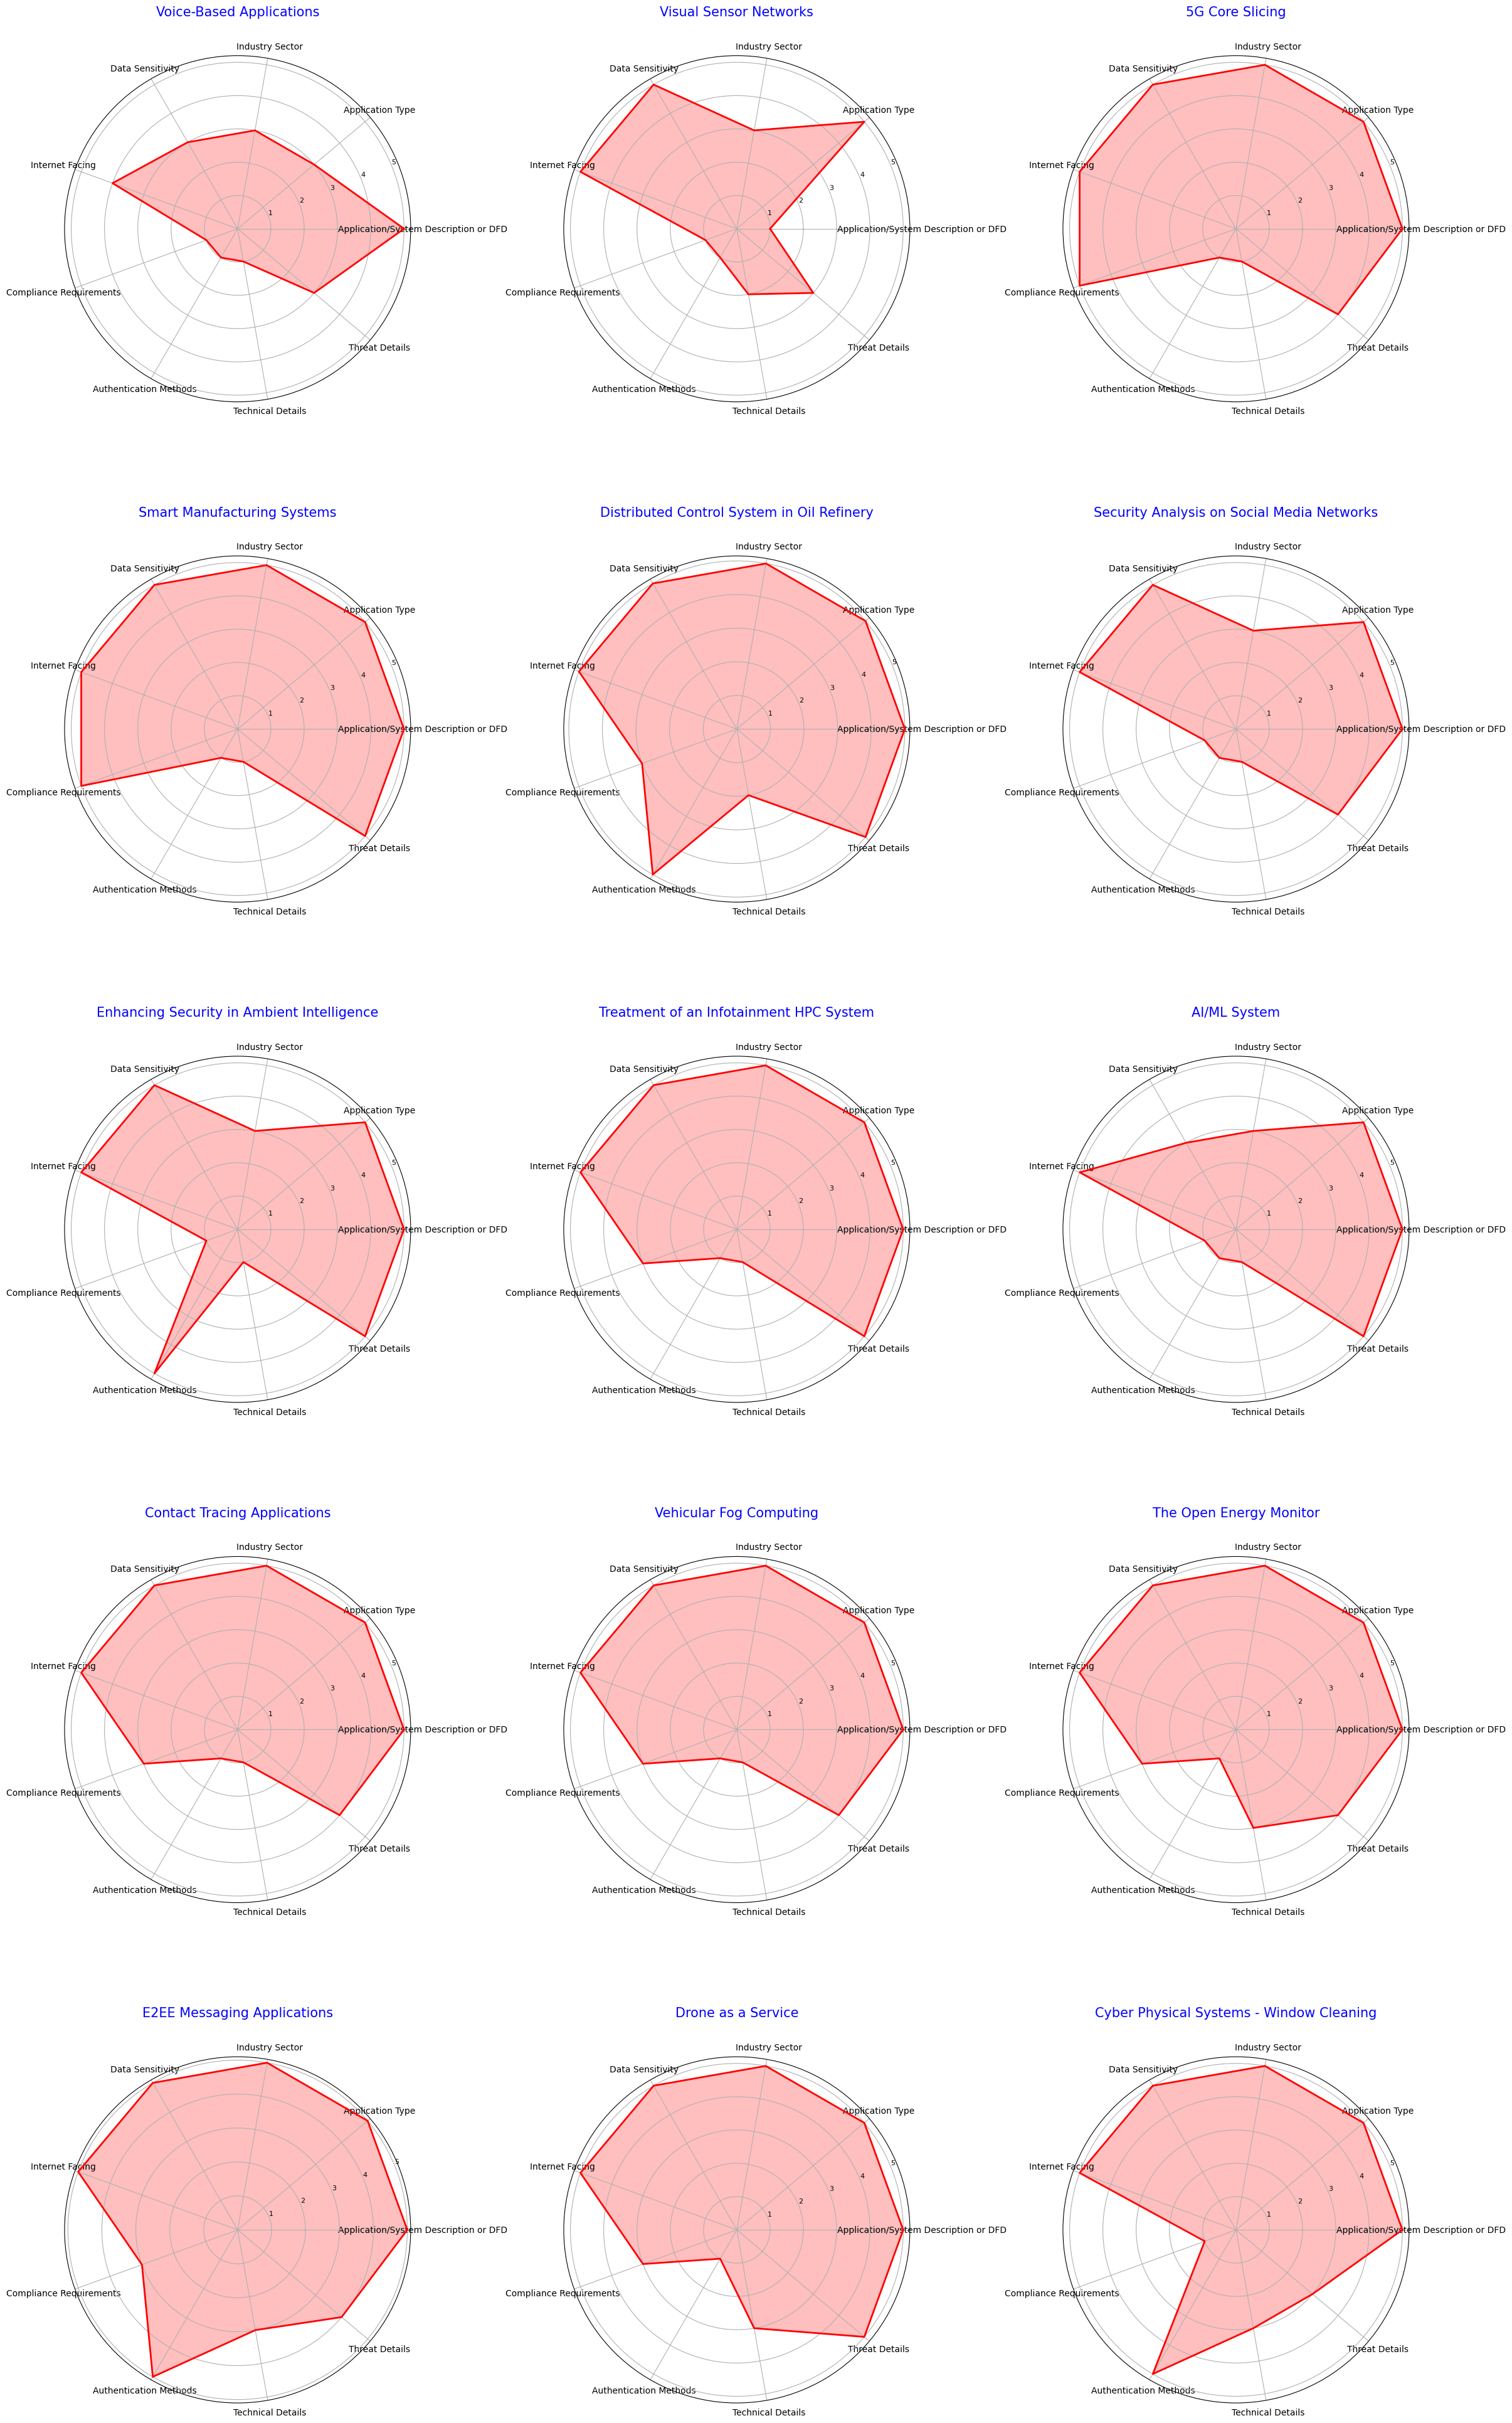

In [8]:
# Show the variance in the type of quality from these case studies

def create_radar_charts_all_in_one(rubric_df):
    # Select the columns representing the categories (exclude 'Case Study', 'Case Study Number', and 'Total Score')
    categories = list(rubric_df.columns[2:-1])
    num_vars = len(categories)

    # Calculate the angles for the radar chart, making sure to close the circle again
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    # Calculate the number of rows and columns for the subplot grid based on the number of case studies
    num_studies = len(rubric_df)
    cols = 3  # Set the number of columns for the subplot grid and hope it all fits!
    rows = (num_studies // cols) + (num_studies % cols > 0)  # Dynamically calculate the number of rows

    # Create a grid of subplots, each of which will contain a radar chart
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 8), subplot_kw=dict(polar=True))
    axes = axes.flatten()  # Flatten the axes array for easier indexing

    # Loop through each case study in the dataframe to generate a radar chart
    for idx, row in rubric_df.iterrows():
        # Extract the values for each category, making sure to close the circle by repeating the first value
        values = row[2:-1].tolist()
        values += values[:1]

        # Draw the radar chart on the corresponding subplot
        ax = axes[idx]
        ax.fill(angles, values, color='red', alpha=0.25)
        ax.plot(angles, values, color='red', linewidth=2)

        # Set the category labels on the radar chart axes
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=10)

        # Set the title of each radar chart to the case study name
        ax.set_title(f'{row["Case Study"]}', size=15, color='blue', y=1.1)

    # Hide any unused subplots if the number of case studies doesn't fill the entire grid
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    # Adjust the layout to prevent overlap between subplots
    plt.tight_layout()
    plt.show()

# Generate radar charts for all case studies in one image
# The chart will grow with your screen if it is hard to see
create_radar_charts_all_in_one(rubric_df)


# Hypothesis 1

## Run flesch_kincaid_grade

H1: A generative AI-enhanced threat modeling tool can reduce the complexity of threat descriptions compared to expert-developed models while maintaining comprehensive coverage of threat categories.


---
What are we covering?

*   **A generative AI-enhanced threat modeling tool can reduce the complexity of threat descriptions compared to expert-developed models:**
    * Can we drop the grade level via flesch kincaid to something that is statistically significant.
*   **while maintaining comprehensive coverage of threat categories.:**
    * Still keep the threat covereage to 3 threats for every STRIDE category.


In [9]:
from textstat import flesch_kincaid_grade

# Define a list to collect the readability data
readability_data = []

# Process the tool-generated data from tool_results_df
for idx, row in tool_results_df.iterrows():
    case_study_number = row['Case Study Number']
    batch_number = row['Batch Number']
    tool_threat_scenario = row['Scenario']  # Tool-generated scenario
    tool_score = flesch_kincaid_grade(tool_threat_scenario)  # Calculate Flesch-Kincaid score for the tool

    # Append tool-generated threat scenario and score to the list
    readability_data.append({
        'Case': case_study_number,
        'Batch': batch_number,
        'Threat_Source': 'Tool',
        'Threat_Scenario': tool_threat_scenario,
        'Flesch_Kincaid_Score': tool_score
    })

# Process the expert-generated data from case_results_df
for idx, row in case_results_df.iterrows():
    case_study_number = row['Case Study Number']
    paper_threat_scenario = row['Scenario']  # Expert-generated scenario
    paper_score = flesch_kincaid_grade(paper_threat_scenario)  # Calculate Flesch-Kincaid score for the expert

    # Append expert-generated threat scenario and score to the list
    readability_data.append({
        'Case': case_study_number,
        'Batch': 'Unknown',  # No batch number in paper file
        'Threat_Source': 'Paper',
        'Threat_Scenario': paper_threat_scenario,
        'Flesch_Kincaid_Score': paper_score
    })

# Convert the list of dictionaries to a DataFrame
readability_df = pd.DataFrame(readability_data)

# save the DataFrame to a CSV file for further analysis and save myself the headache in case I do something wrong
readability_df.to_csv('readability_scores.csv', index=False)

# Print the first few rows to verify the output for sanity purposes
#readability_df.head()
readability_df.describe()

,Flesch_Kincaid_Score
count,8343.000000
mean,13.824037
std,3.013668
min,-2.620000
25%,11.784286
50%,13.718889
75%,15.725000
max,28.846667


## Normality Test Results: Readability


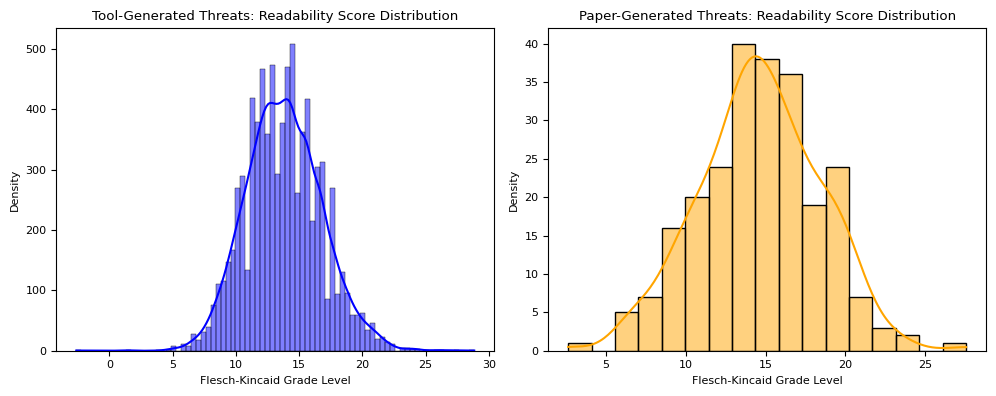


--- Normality Test Results ---

Tool-Generated Threats:
Anderson-Darling Statistic: 5.5756
K-S p-value: 0.0000

Paper-Generated Threats:
Shapiro-Wilk p-value: 0.7778
K-S p-value: 0.9150


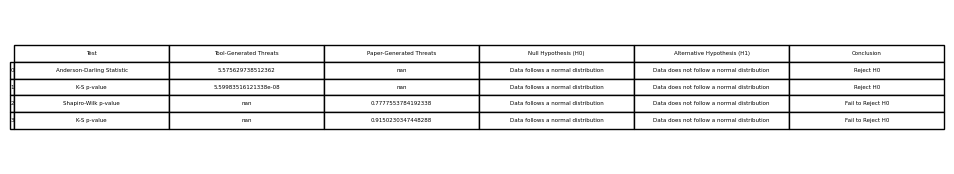

In [10]:
from scipy.stats import shapiro, kstest, anderson


# Set the font size globally and hope it sticks
plt.rcParams.update({'font.size': 8})

# Separate tool-generated and paper-generated threats
tool_scores = readability_df[readability_df['Threat_Source'] == 'Tool']['Flesch_Kincaid_Score']
paper_scores = readability_df[readability_df['Threat_Source'] == 'Paper']['Flesch_Kincaid_Score']

# Perform normality tests for tool-generated scores
anderson_tool = anderson(tool_scores)  # Anderson-Darling for large datasets (8100 in the tool threat df)
kstool = kstest(tool_scores, 'norm', args=(tool_scores.mean(), tool_scores.std()))

# Perform normality tests for paper-generated scores
shapiro_paper = shapiro(paper_scores)  # Shapiro-Wilk for smaller datasets (218 in the case study threat df)
kspaper = kstest(paper_scores, 'norm', args=(paper_scores.mean(), paper_scores.std()))

# Create subplots to display both distributions in a single image
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot for tool-generated threats (left)
sns.histplot(tool_scores, kde=True, color='blue', ax=ax[0])
ax[0].set_title('Tool-Generated Threats: Readability Score Distribution')
ax[0].set_xlabel('Flesch-Kincaid Grade Level')
ax[0].set_ylabel('Density')

# Plot for paper-generated threats (right)
sns.histplot(paper_scores, kde=True, color='orange', ax=ax[1])
ax[1].set_title('Paper-Generated Threats: Readability Score Distribution')
ax[1].set_xlabel('Flesch-Kincaid Grade Level')
ax[1].set_ylabel('Density')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print normality test results below the graphs
print("\n--- Normality Test Results ---")
print("\nTool-Generated Threats:")
print(f"Anderson-Darling Statistic: {anderson_tool.statistic:.4f}")
print(f"K-S p-value: {kstool.pvalue:.4f}")

print("\nPaper-Generated Threats:")
print(f"Shapiro-Wilk p-value: {shapiro_paper.pvalue:.4f}")
print(f"K-S p-value: {kspaper.pvalue:.4f}")

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Define your actual test results
anderson_tool_stat = anderson_tool.statistic
kstool_pvalue = kstool.pvalue
shapiro_paper_pvalue = shapiro_paper.pvalue
kspaper_pvalue = kspaper.pvalue

# Create the test results dynamically - I ended up using Minitab and Ryan-Joiner test for normality
data = {
    "Test": ["Anderson-Darling Statistic", "K-S p-value", "Shapiro-Wilk p-value", "K-S p-value"],
    "Tool-Generated Threats": [anderson_tool_stat, kstool_pvalue, None, None],
    "Paper-Generated Threats": [None, None, shapiro_paper_pvalue, kspaper_pvalue],
    "Null Hypothesis (H0)": [
        "Data follows a normal distribution",
        "Data follows a normal distribution",
        "Data follows a normal distribution",
        "Data follows a normal distribution"
    ],
    "Alternative Hypothesis (H1)": [
        "Data does not follow a normal distribution",
        "Data does not follow a normal distribution",
        "Data does not follow a normal distribution",
        "Data does not follow a normal distribution"
    ],
    "Conclusion": [
        "Reject H0" if anderson_tool_stat > anderson_tool.critical_values[2] else "Fail to Reject H0",
        "Reject H0" if kstool_pvalue < 0.05 else "Fail to Reject H0",
        "Reject H0" if shapiro_paper_pvalue < 0.05 else "Fail to Reject H0",
        "Reject H0" if kspaper_pvalue < 0.05 else "Fail to Reject H0"
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot the table as an image using matplotlib
fig, ax = plt.subplots(figsize=(10, 2)) # Adjust figure size
ax.axis('tight')
ax.axis('off')

# Create a table plot
table_data = table(ax, df, loc='center', cellLoc = 'center', colWidths=[0.2]*len(df.columns))

# Save the table as an image
plt.savefig("normality_test_results_table_fixed.png", bbox_inches='tight', dpi=300)

plt.show()



In [11]:
from scipy.stats import shapiro, kstest, anderson
import numpy as np
import pandas as pd
from scipy import stats

# Unfortunately, there were some negative results I have to deal with in these transform tests

# Separate tool-generated and paper-generated threats based on 'Threat_Source'
tool_scores = readability_df[readability_df['Threat_Source'] == 'Tool']['Flesch_Kincaid_Score']
paper_scores = readability_df[readability_df['Threat_Source'] == 'Paper']['Flesch_Kincaid_Score']

# Filter out negative values from tool-generated scores and log-transform the result
tool_scores_filtered = tool_scores[tool_scores > 0]
print(f"Number of Tool Scores Filtered: {len(tool_scores_filtered)}")
print(f"Number of Tool Scores Not Filtered: {len(tool_scores) - len(tool_scores_filtered)}")

log_tool_scores_filtered = np.log1p(tool_scores_filtered)  # log1p handles zero safely

# Run normality tests on log-transformed scores
anderson_log_filtered = anderson(log_tool_scores_filtered)
kstool_log_filtered = kstest(log_tool_scores_filtered, 'norm', args=(log_tool_scores_filtered.mean(), log_tool_scores_filtered.std()))

print("\n--- Normality Test Results After Filtering and Log Transformation (Tool-Generated Threats) ---")
print(f"Anderson-Darling Statistic (Log-Filtered Tool): {anderson_log_filtered.statistic:.4f}")
print(f"K-S p-value (Log-Filtered Tool): {kstool_log_filtered.pvalue:.4f}")

# Replace negative values with a small constant (0.1) and log-transform
tool_scores_adjusted = tool_scores.apply(lambda x: x if x > 0 else 0.1)
log_tool_scores_adjusted = np.log1p(tool_scores_adjusted)

# Run normality tests on log-transformed scores after adjusting negatives
anderson_log_adjusted = anderson(log_tool_scores_adjusted)
kstool_log_adjusted = kstest(log_tool_scores_adjusted, 'norm', args=(log_tool_scores_adjusted.mean(), log_tool_scores_adjusted.std()))

print("\n--- Normality Test Results After Adjusting and Log Transformation (Tool-Generated Threats) ---")
print(f"Anderson-Darling Statistic (Log-Adjusted Tool): {anderson_log_adjusted.statistic:.4f}")
print(f"K-S p-value (Log-Adjusted Tool): {kstool_log_adjusted.pvalue:.4f}")

# Apply Box-Cox transformation (replace negatives with 0.1 first)
tool_scores_adjusted_for_boxcox = tool_scores.apply(lambda x: x if x > 0 else 0.1)
boxcox_tool_scores, _ = stats.boxcox(tool_scores_adjusted_for_boxcox + 1)  # Box-Cox needs positive values

# Run normality tests on Box-Cox transformed scores
anderson_boxcox_tool = anderson(boxcox_tool_scores)
kstest_boxcox_tool = kstest(boxcox_tool_scores, 'norm', args=(boxcox_tool_scores.mean(), boxcox_tool_scores.std()))

print("\n--- Normality Test Results After Box-Cox Transformation (Tool-Generated Threats) ---")
print(f"Anderson-Darling Statistic (Box-Cox Tool): {anderson_boxcox_tool.statistic:.4f}")
print(f"K-S p-value (Box-Cox Tool): {kstest_boxcox_tool.pvalue:.4f}")

# Normality tests for paper-generated threats (no transformation needed)
shapiro_paper = shapiro(paper_scores)
kspaper = kstest(paper_scores, 'norm', args=(paper_scores.mean(), paper_scores.std()))

print("\n--- Normality Test Results for Paper-Generated Threats (unchanged) ---")
print(f"Shapiro-Wilk p-value (Paper): {shapiro_paper.pvalue:.4f}")
print(f"K-S p-value (Paper): {kspaper.pvalue:.4f}")


Number of Tool Scores Filtered: 8099
Number of Tool Scores Not Filtered: 1

--- Normality Test Results After Filtering and Log Transformation (Tool-Generated Threats) ---
Anderson-Darling Statistic (Log-Filtered Tool): 18.0768
K-S p-value (Log-Filtered Tool): 0.0000

--- Normality Test Results After Adjusting and Log Transformation (Tool-Generated Threats) ---
Anderson-Darling Statistic (Log-Adjusted Tool): 19.4616
K-S p-value (Log-Adjusted Tool): 0.0000

--- Normality Test Results After Box-Cox Transformation (Tool-Generated Threats) ---
Anderson-Darling Statistic (Box-Cox Tool): 2.2744
K-S p-value (Box-Cox Tool): 0.0003

--- Normality Test Results for Paper-Generated Threats (unchanged) ---
Shapiro-Wilk p-value (Paper): 0.7778
K-S p-value (Paper): 0.9150


## **Results: Hypothesis 1**

A **Mann-Whitney U test** was performed to compare the Flesch-Kincaid grade levels of the tool-generated and expert-developed threats. The goal was to evaluate whether the AI-enhanced tool significantly reduces the complexity of threat descriptions compared to expert-developed models while maintaining comprehensive coverage of threat categories.

#### **Test Setup**:
- **Null Hypothesis (H0)**: There is no significant difference between the readability scores of tool-generated and paper-generated threats.
- **Alternative Hypothesis (H1)**: The tool-generated threats have a lower grade level, meaning they are simpler.



--- Plot 1: Distribution of Flesch-Kincaid Grade Levels: Tool vs Paper Threats ---



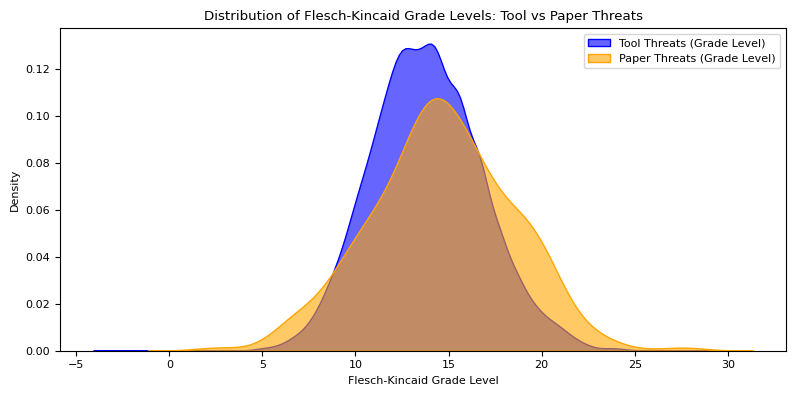

Average Tool Flesch-Kincaid Grade Level: 13.80
Average Paper Flesch-Kincaid Grade Level: 14.64
Tool Threats Percentiles (25th, 50th, 75th):
0.25    11.760101
0.50    13.673333
0.75    15.725000
Name: Flesch_Kincaid_Score, dtype: float64
Paper Threats Percentiles (25th, 50th, 75th):
0.25    12.293333
0.50    14.630000
0.75    17.006667
Name: Flesch_Kincaid_Score, dtype: float64
The tool-generated threat descriptions are simpler (lower grade level).

--- Plot 2: Box Plot of Grade Level Distribution: Tool vs Paper Threats ---



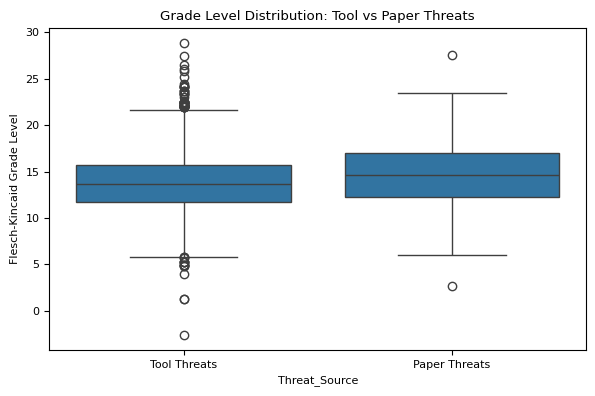


--- Mann-Whitney U Test for Statistical Significance ---

A Mann-Whitney U test was performed to compare the Flesch-Kincaid grade levels of the tool-generated
and expert-developed threats. The goal was to evaluate whether the AI-enhanced tool significantly reduces the complexity
of threat descriptions compared to expert-developed models while maintaining comprehensive coverage of threat categories.

Test Setup:
  Null Hypothesis (H0): There is no significant difference between the readability scores of tool-generated and paper-generated threats.
  Alternative Hypothesis (H1): The tool-generated threats have a lower grade level, meaning they are simpler.

A p-value below 0.05 indicates that the difference in grade levels is statistically significant.
----------------------------------------------------------------------------------------------

Note: While preliminary results were calculated using scipy.stats, final values reported
below were obtained using Minitab, which provided clea

In [30]:
from scipy.stats import mannwhitneyu

# Separate tool-generated and paper-generated threats
tool_scores = readability_df[readability_df['Threat_Source'] == 'Tool']['Flesch_Kincaid_Score']
paper_scores = readability_df[readability_df['Threat_Source'] == 'Paper']['Flesch_Kincaid_Score']

# --- Step 1: Visualize the Distribution of Readability Scores (Grade Levels) ---
print("\n--- Plot 1: Distribution of Flesch-Kincaid Grade Levels: Tool vs Paper Threats ---\n")
plt.figure(figsize=(8, 4))
sns.kdeplot(tool_scores, label='Tool Threats (Grade Level)', fill=True, color='blue', alpha=0.6)
sns.kdeplot(paper_scores, label='Paper Threats (Grade Level)', fill=True, color='orange', alpha=0.6)
plt.title('Distribution of Flesch-Kincaid Grade Levels: Tool vs Paper Threats')
plt.xlabel('Flesch-Kincaid Grade Level')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# --- Step 2: Calculate the Average Grade Levels ---
avg_tool_score = tool_scores.mean()
avg_paper_score = paper_scores.mean()

print(f"Average Tool Flesch-Kincaid Grade Level: {avg_tool_score:.2f}")
print(f"Average Paper Flesch-Kincaid Grade Level: {avg_paper_score:.2f}")

# --- Step 3: Percentile Analysis ---
percentiles_tool = tool_scores.quantile([0.25, 0.5, 0.75])
percentiles_paper = paper_scores.quantile([0.25, 0.5, 0.75])

print(f"Tool Threats Percentiles (25th, 50th, 75th):\n{percentiles_tool}")
print(f"Paper Threats Percentiles (25th, 50th, 75th):\n{percentiles_paper}")

# --- Step 4: Hypothesis Testing (Is the Tool Simpler?) ---
# Check if the tool-generated threats have a lower grade level than the paper threats
if avg_tool_score < avg_paper_score:
    print(f"The tool-generated threat descriptions are simpler (lower grade level).")
else:
    print(f"The tool-generated threat descriptions are not simpler (higher grade level).")

# --- Step 5: Box Plot for Grade Level Distribution ---
print("\n--- Plot 2: Box Plot of Grade Level Distribution: Tool vs Paper Threats ---\n")
combined_data = pd.DataFrame({
    'Grade_Level': pd.concat([tool_scores, paper_scores], axis=0),
    'Threat_Source': ['Tool Threats'] * len(tool_scores) + ['Paper Threats'] * len(paper_scores)
})

plt.figure(figsize=(6, 4))
sns.boxplot(x='Threat_Source', y='Grade_Level', data=combined_data)
plt.title('Grade Level Distribution: Tool vs Paper Threats')
plt.ylabel('Flesch-Kincaid Grade Level')
plt.tight_layout()
plt.show()
# --- Step 6: Mann-Whitney U Test for Statistical Significance ---
# Perform the Mann-Whitney U test (non-parametric alternative to t-test)
# Set the alternative hypothesis to 'less' since we expect tool_scores < paper_scores
u_stat, p_value_u = mannwhitneyu(tool_scores, paper_scores, alternative='less')

# Output the results of the Mann-Whitney U test and explain the findings
print("\n--- Mann-Whitney U Test for Statistical Significance ---")
print("\nA Mann-Whitney U test was performed to compare the Flesch-Kincaid grade levels of the tool-generated")
print("and expert-developed threats. The goal was to evaluate whether the AI-enhanced tool significantly reduces the complexity")
print("of threat descriptions compared to expert-developed models while maintaining comprehensive coverage of threat categories.")
print("\nTest Setup:")
print("  Null Hypothesis (H0): There is no significant difference between the readability scores of tool-generated and paper-generated threats.")
print("  Alternative Hypothesis (H1): The tool-generated threats have a lower grade level, meaning they are simpler.")
print("\nA p-value below 0.05 indicates that the difference in grade levels is statistically significant.")

# Output the results
print("----------------------------------------------------------------------------------------------")
print("")
print("Note: While preliminary results were calculated using scipy.stats, final values reported")
print("below were obtained using Minitab, which provided clearer output and automatic tie adjustment.")
print("")
print("----------------------------------------------------------------------------------------------")
print(f"\nMann-Whitney U statistic: {u_stat:.4f}, P-value: {p_value_u:.4f}")
if p_value_u < 0.05:
    print("\nThe difference in grade levels is statistically significant (p < 0.05).")
    print(f"Tool Grade Level: {avg_tool_score:.2f} is statistically lower than Paper Grade Level: {avg_paper_score:.2f}")
    print("The null hypothesis is rejected, and it can be concluded that the tool-generated threats are simpler.")
else:
    print("\nThe difference in grade levels is not statistically significant (p >= 0.05).")
    print(f"Tool Grade Level: {avg_tool_score:.2f} is not statistically different from Paper Grade Level: {avg_paper_score:.2f}")
    print("The null hypothesis cannot be rejected, indicating that the tool may not have significantly reduced the complexity.")



# Hypothesis 2

## Run Cosine Similarity Scoring
A generative AI-enhanced threat modeling tool can generate outputs that exhibit semantic similarity to expert-developed models, as indicated by cosine similarity using Sentence-BERT, regardless of the specific domain.


---
What are we covering?

*   **A generative AI-enhanced threat modeling tool can generate outputs that exhibit semantic similarity to expert-developed models, as indicated by cosine similarity using Sentence-BERT**
    * -1 to 1 with 0.7 designated as the cosine similarity threshold.
*   **regardless of the specific domain**
    * Among 15 Case Studies

---
Use an A100 to run this.

---

In [13]:
import warnings
import torch
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Suppress specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message=r".*clean_up_tokenization_spaces.*")

# Verify and set the device to A100 GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU in use: {gpu_name}")

# Load the pre-trained model for semantic similarity on the specified device
model = SentenceTransformer("stsb-roberta-large", device=device)

# Prepare a dictionary to store expert embeddings per case study number
expert_embeddings_dict = {}

# Compute embeddings for expert scenarios grouped by case study number
for case_number, group in case_results_df.groupby('Case Study Number'):
    expert_scenarios = group['Scenario'].tolist()
    expert_threat_types = group['Threat Type'].tolist()  # Ensure 'Threat Type' is a column in case_results_df
    # Compute embeddings on the GPU
    expert_embeddings = model.encode(
        expert_scenarios,
        batch_size=128,          # Increased batch size for A100 GPU
        device=device,
        convert_to_numpy=True
    )
    # Store expert scenarios, embeddings, and threat types
    expert_embeddings_dict[case_number] = {
        'scenarios': expert_scenarios,
        'embeddings': expert_embeddings,
        'threat_types': expert_threat_types  # Add expert threat types
    }

# Prepare a list to store the combined data
similarity_comparison_data = []

# Process tool scenarios grouped by case study number
for case_number, group in tool_results_df.groupby('Case Study Number'):
    # Check if expert embeddings are available for this case number
    if case_number not in expert_embeddings_dict:
        continue

    tool_scenarios = group['Scenario'].tolist()
    batch_numbers = group['Batch Number'].tolist()
    tool_threat_types = group['Threat Type'].tolist()  # Ensure 'Threat Type' is a column in tool_results_df

    # Get precomputed expert embeddings
    expert_data = expert_embeddings_dict[case_number]
    expert_scenarios = expert_data['scenarios']
    expert_embeddings = expert_data['embeddings']
    expert_threat_types = expert_data['threat_types']  # Retrieve expert threat types

    # Compute embeddings for tool scenarios on the GPU
    tool_embeddings = model.encode(
        tool_scenarios,
        batch_size=128,          # Increased batch size for A100 GPU
        device=device,
        convert_to_numpy=True
    )

    # Compute cosine similarities
    similarities = cosine_similarity(tool_embeddings, expert_embeddings)

    # Store the similarities along with the expert threat type
    for i in range(len(tool_scenarios)):
        for j in range(len(expert_scenarios)):
            similarity_comparison_data.append([
                case_number,                     # Case Number
                batch_numbers[i],                # Batch Number
                tool_threat_types[i],            # Tool Threat Type
                tool_scenarios[i],               # Tool Threat Scenario
                expert_threat_types[j],          # Case Threat Type (Expert Threat Type)
                expert_scenarios[j],             # Case Threat (Expert Scenario)
                similarities[i][j]               # Similarity Score
            ])

# Create a DataFrame to store the similarity comparison results
similarity_comparison_df = pd.DataFrame(similarity_comparison_data, columns=[
    "Case Number", "Batch Number", "Tool Threat Type", "Tool Threat Scenario", "Case Threat Type", "Case Threat", "Score"
])

# Adjust display options and show the DataFrame
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
print(similarity_comparison_df.head())

# Save the DataFrame to a CSV file
similarity_comparison_df.to_csv('similarity_comparison.csv', index=False)


Using device: cuda
GPU in use: Tesla T4


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

  Case Number Batch Number Tool Threat Type                                                         Tool Threat Scenario   Case Threat Type                                                                                                                                                                                                                                                                                    Case Threat     Score
0           1            1         Spoofing  An attacker uses voice imitation software to impersonate a legitimate user.           Spoofing  Audio signal: If no authentication mechanism is established between the server side and the client side of a voice-based application, a spoofing attack is possible. In other words, an unauthorized audio signal can be sent to the server side of a voice-based application by an attacker.  0.693459
1           1            1         Spoofing  An attacker uses voice imitation software to impersonate a legitimate user.      

In [14]:
# Filter the DataFrame to keep only rows where the tool and case threat types are the same
matching_threat_types_df = similarity_comparison_df[
    similarity_comparison_df['Tool Threat Type'] == similarity_comparison_df['Case Threat Type']
]

# Display the filtered DataFrame
print(matching_threat_types_df.head())

# Optionally, save the filtered DataFrame to a CSV file
matching_threat_types_df.to_csv('matching_threat_type_scores.csv', index=False)


   Case Number Batch Number Tool Threat Type                                                                             Tool Threat Scenario Case Threat Type                                                                                                                                                                                                                                                                                    Case Threat     Score
0            1            1         Spoofing                      An attacker uses voice imitation software to impersonate a legitimate user.         Spoofing  Audio signal: If no authentication mechanism is established between the server side and the client side of a voice-based application, a spoofing attack is possible. In other words, an unauthorized audio signal can be sent to the server side of a voice-based application by an attacker.  0.693459
1            1            1         Spoofing                      An attacker uses voice

In [15]:
matching_threat_types_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21870 entries, 0 to 131219
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Case Number           21870 non-null  object 
 1   Batch Number          21870 non-null  object 
 2   Tool Threat Type      21870 non-null  object 
 3   Tool Threat Scenario  21870 non-null  object 
 4   Case Threat Type      21870 non-null  object 
 5   Case Threat           21870 non-null  object 
 6   Score                 21870 non-null  float32
dtypes: float32(1), object(6)
memory usage: 1.3+ MB


## Results
*A generative AI-enhanced threat modeling tool can generate outputs that exhibit semantic similarity to expert-developed models, as indicated by cosine similarity using Sentence-BERT, regardless of the specific domain.*


### **Summary of the Results: Hypothesis 2**

#### **Objective**:
The AI-enhanced threat modeling tool was evaluated across 15 case studies to determine if it could generate threats that are semantically similar to expert-developed models. The tool was run **30 times per case study**, generating **18 threats per run** (for a total of **540 threats per case study**). A cosine similarity threshold of **≥ 0.7** was used to measure semantic similarity. The tool was considered successful if at least one threat in 50% of the runs met or exceeded this threshold. MAJORITY VOTE!






--- Overall Analysis Including All Scores ---

--- Statistical Summary of Similarity Scores per Case Number (All Scores) ---

    Case Number  count      mean       std       min       max
0             1   1440  0.564804  0.114941  0.094066  0.874323
1             2   1080  0.541473  0.134864  0.091872  0.831022
2             3   1800  0.489556  0.142424 -0.002546  0.857963
3             4    900  0.519060  0.105636  0.176521  0.823524
4             5   1170  0.499052  0.131592  0.091119  0.819052
5             6   1350  0.441817  0.144253  0.080196  0.810316
6             7   2610  0.515564  0.137191  0.000817  0.941983
7             8   2880  0.545585  0.117164  0.017705  0.868055
8             9   1170  0.481896  0.126989  0.079620  0.890803
9            10   1170  0.544601  0.137159  0.128692  0.892365
10           11    990  0.542251  0.135849  0.081111  0.896690
11           12   1350  0.481541  0.117399  0.135225  0.793191
12           13    990  0.527351  0.105120  0.182281  

<ipython-input-16-830cd6351b87>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Case Number'] = df['Case Number'].astype(int)
<ipython-input-16-830cd6351b87>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Batch Number'] = df['Batch Number'].astype(int)


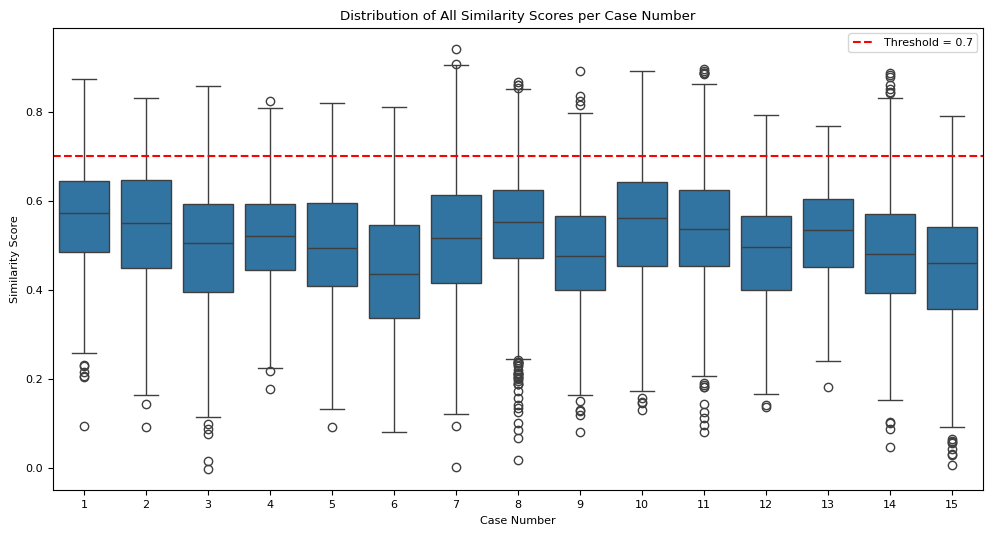


--- Analysis for Threshold: 0.7 ---

Number of rows in filtered_df: 1594


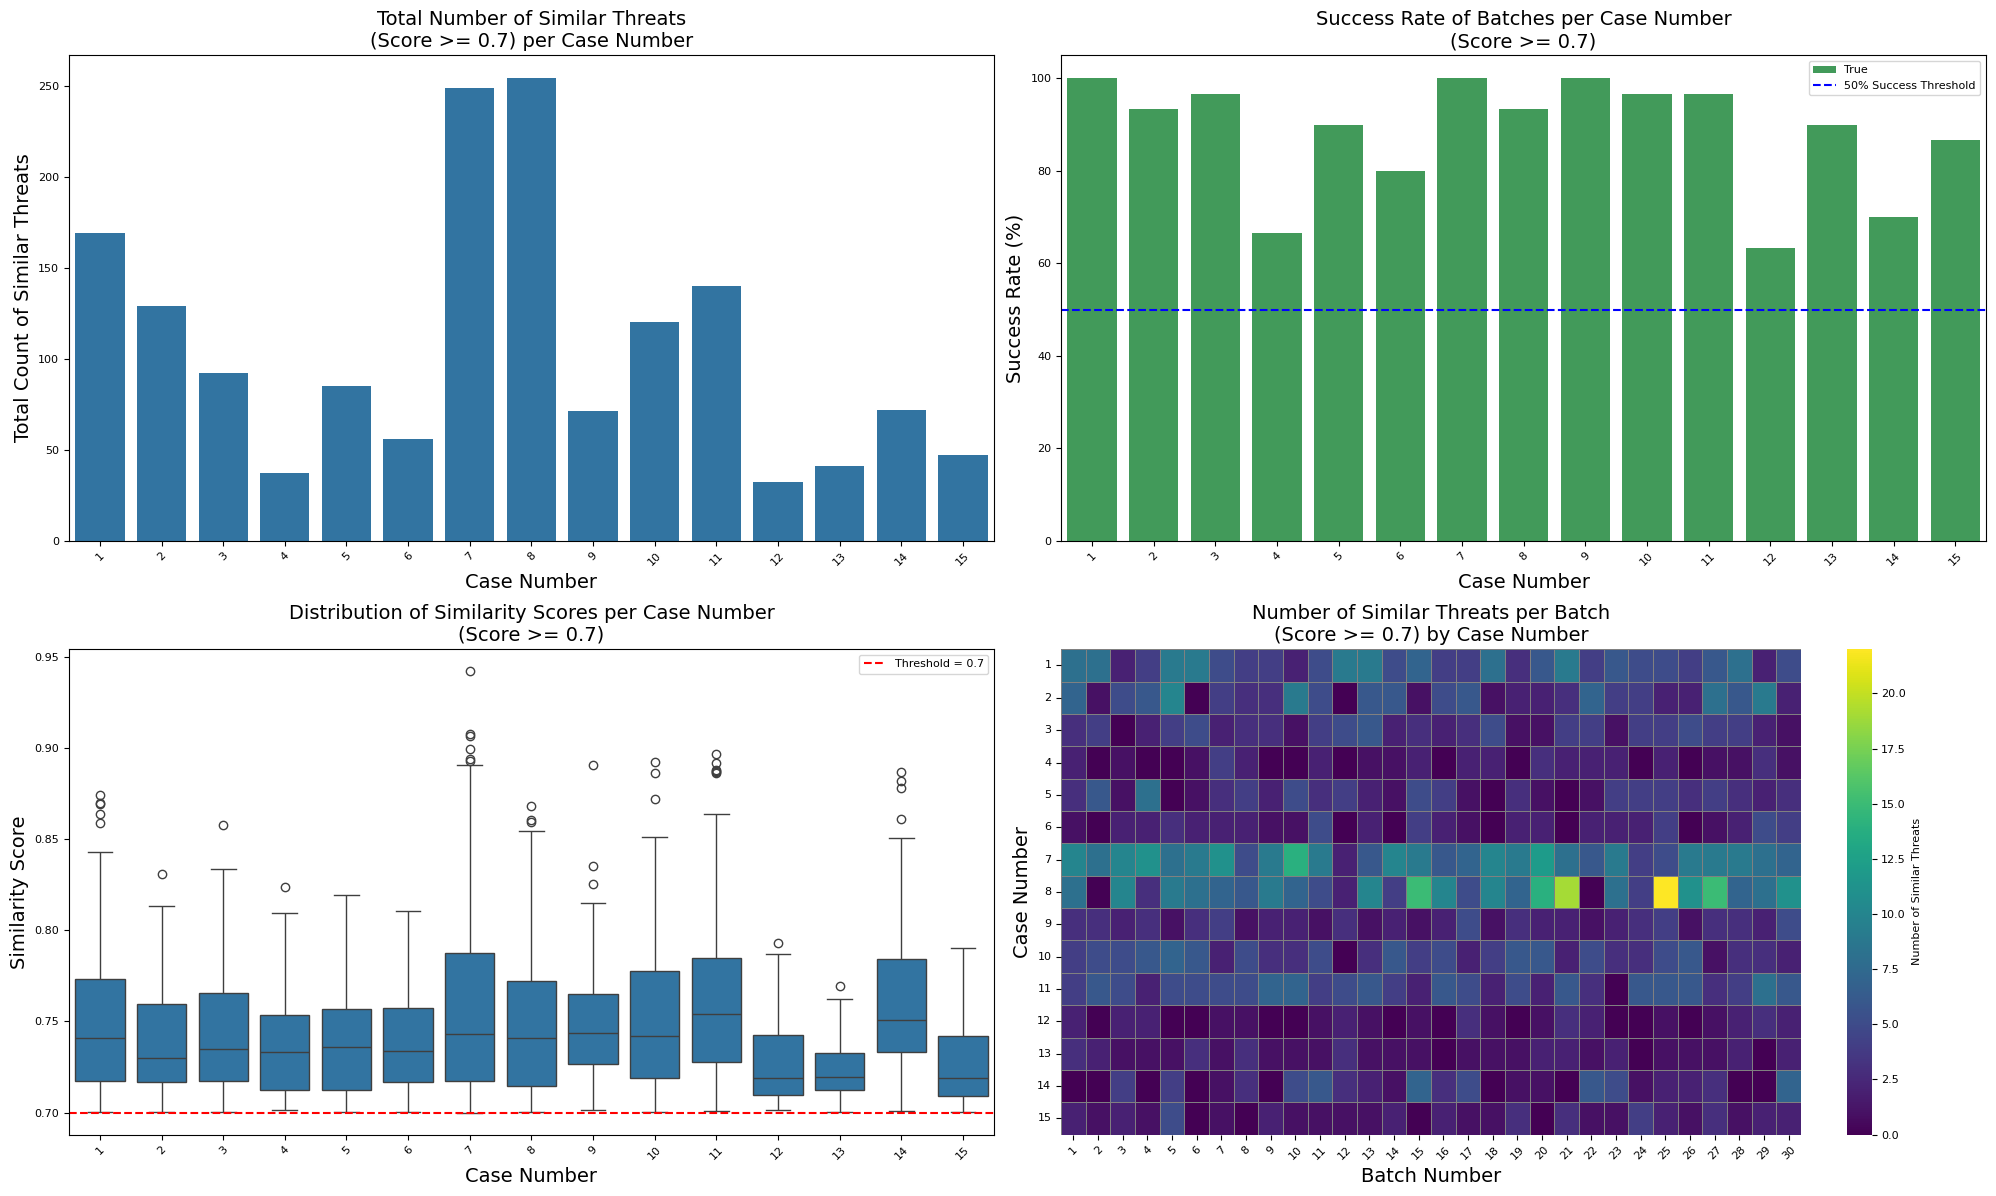

    Case Number  count      mean       std       min       max
0             1    169  0.750147  0.040116  0.700393  0.874323
1             2    129  0.739586  0.029373  0.700025  0.831022
2             3     92  0.744656  0.034637  0.700026  0.857963
3             4     37  0.736260  0.031379  0.701329  0.823524
4             5     85  0.737684  0.029000  0.700132  0.819052
5             6     56  0.741064  0.029948  0.700338  0.810316
6             7    249  0.756191  0.048743  0.700013  0.941983
7             8    254  0.748516  0.040191  0.700224  0.868055
8             9     71  0.748808  0.034607  0.701639  0.890803
9            10    120  0.753545  0.043142  0.700131  0.892365
10           11    140  0.766271  0.050853  0.700984  0.896690
11           12     32  0.728748  0.025985  0.701233  0.793191
12           13     41  0.724338  0.017079  0.700287  0.769201
13           14     72  0.763117  0.046930  0.700847  0.886651
14           15     47  0.726297  0.021776  0.700355  0

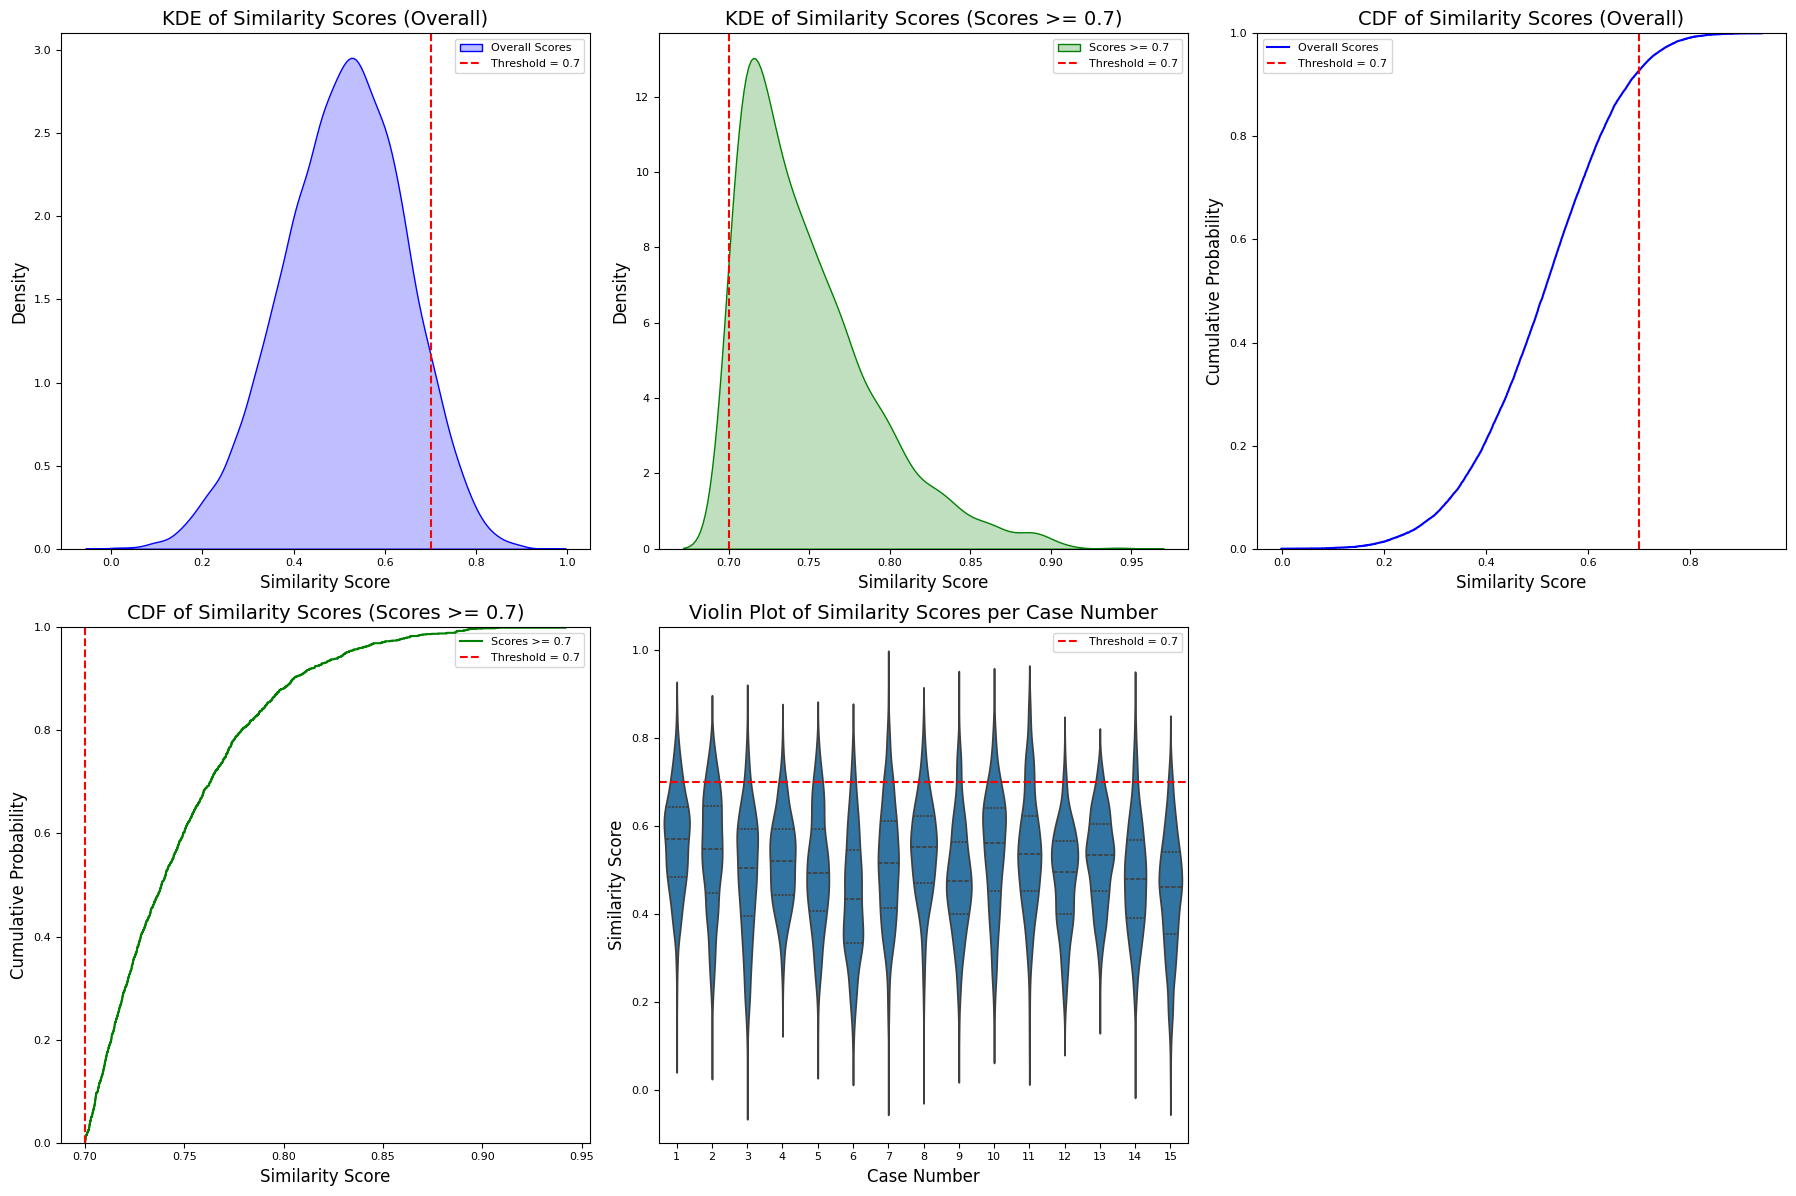

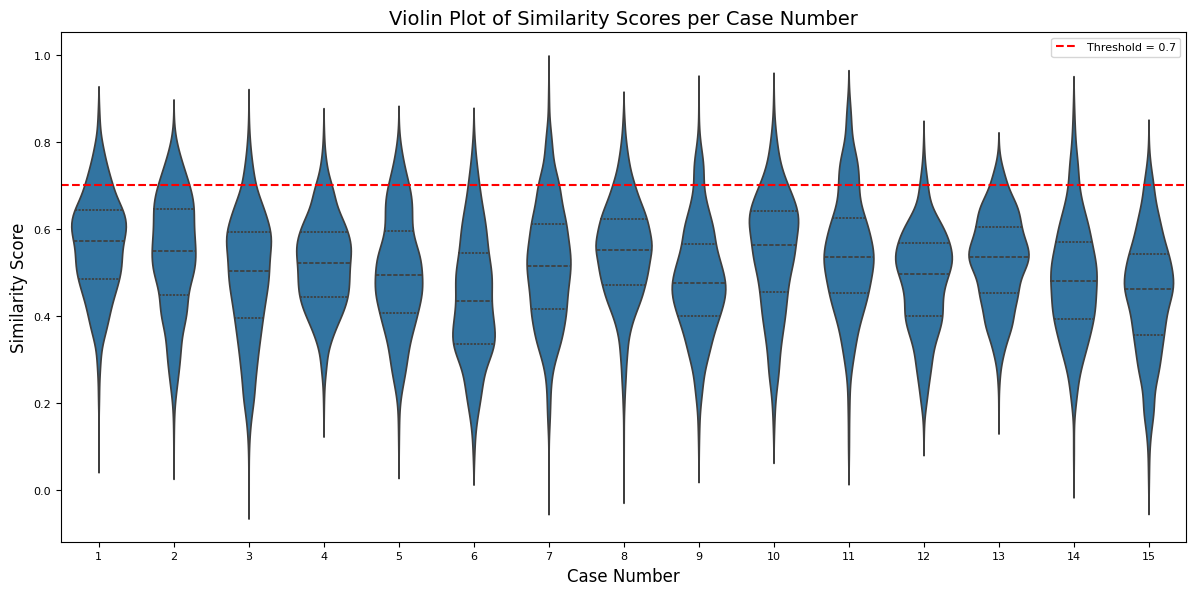

In [16]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns

# Use the matching threat types DataFrame for analysis
df = matching_threat_types_df

# Convert 'Case Number' and 'Batch Number' to integers for proper numerical sorting
df['Case Number'] = df['Case Number'].astype(int)
df['Batch Number'] = df['Batch Number'].astype(int)

# Set the similarity threshold
threshold = 0.70

print("\n--- Overall Analysis Including All Scores ---\n")

# --- Overall Statistical Summary per Case Number ---
overall_stats_df = df.groupby('Case Number')['Score'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
print("--- Statistical Summary of Similarity Scores per Case Number (All Scores) ---\n")
print(overall_stats_df)

# --- Plot: Distribution of All Similarity Scores per Case Number ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='Case Number', y='Score', data=df, order=sorted(df['Case Number'].unique()))
plt.title('Distribution of All Similarity Scores per Case Number')
plt.xlabel('Case Number')
plt.ylabel('Similarity Score')
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
plt.legend()
plt.show()

# Now, perform the analysis for scores >= threshold
print(f"\n--- Analysis for Threshold: {threshold} ---\n")

# Filter rows where the similarity score is >= threshold
filtered_df = df[df['Score'] >= threshold]
print(f"Number of rows in filtered_df: {len(filtered_df)}")

if filtered_df.empty:
    print(f"No data points with Score >= {threshold}. Skipping analysis.")
else:
    # Prepare data for plotting
    batch_counts = filtered_df.groupby(['Case Number', 'Batch Number']).size().reset_index(name='Count')

    # Calculate the total number of results meeting the threshold for each case number
    total_case_counts = filtered_df.groupby('Case Number').size().reset_index(name='Total Count')

    # Count successful batches (batches with at least one result >= threshold) per case number
    batch_success = filtered_df.groupby(['Case Number', 'Batch Number']).size().reset_index(name='Count')
    total_batches_per_case = df.groupby('Case Number')['Batch Number'].nunique().reset_index(name='Total Batches')
    successful_batches = batch_success.groupby('Case Number')['Batch Number'].nunique().reset_index(name='Successful Batches')

    # Merge the total number of batches with the number of successful batches
    success_rate_df = pd.merge(successful_batches, total_batches_per_case, on='Case Number', how='right').fillna(0)

    # Ensure data types are correct
    success_rate_df['Successful Batches'] = success_rate_df['Successful Batches'].astype(int)
    success_rate_df['Total Batches'] = success_rate_df['Total Batches'].astype(int)

    # Calculate the success rate (percentage of batches with at least one result meeting the threshold)
    success_rate_df['Success Rate (%)'] = (success_rate_df['Successful Batches'] / success_rate_df['Total Batches']) * 100

    # Determine which case numbers have a success rate greater than or equal to 50%
    success_rate_df['Met 50% Threshold'] = success_rate_df['Success Rate (%)'] >= 50

    # --- Create subplots ---
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # --- Plot 1: Bar Plot of Total Results per Case Number ---
    total_case_counts = total_case_counts.sort_values(by='Case Number')
    ax = axes[0, 0]
    sns.barplot(x='Case Number', y='Total Count', data=total_case_counts, ax=ax)
    ax.set_title(f'Total Number of Similar Threats\n(Score >= {threshold}) per Case Number', fontsize=14)
    ax.set_xlabel('Case Number', fontsize=14)
    ax.set_ylabel('Total Count of Similar Threats', fontsize=14)
    ax.tick_params(axis='x', rotation=45)

    # --- Plot 2: Success Rate of Batches per Case Number ---
    success_rate_df = success_rate_df.sort_values(by='Case Number')
    ax = axes[0, 1]
    sns.barplot(x='Case Number', y='Success Rate (%)', data=success_rate_df, ax=ax,
                hue='Met 50% Threshold', dodge=False, palette={True: '#34a853', False: '#ea4335'})
    ax.axhline(y=50, color='blue', linestyle='--', label='50% Success Threshold')
    ax.set_title(f'Success Rate of Batches per Case Number\n(Score >= {threshold})', fontsize=14)
    ax.set_xlabel('Case Number', fontsize=14)
    ax.set_ylabel('Success Rate (%)', fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

    # --- Plot 3: Distribution of Similarity Scores per Case Number (Score >= Threshold) ---
    sorted_case_numbers = sorted(filtered_df['Case Number'].unique())
    ax = axes[1, 0]
    sns.boxplot(x='Case Number', y='Score', data=filtered_df, ax=ax, order=sorted_case_numbers)
    ax.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    ax.set_title(f'Distribution of Similarity Scores per Case Number\n(Score >= {threshold})', fontsize=14)
    ax.set_xlabel('Case Number', fontsize=14)
    ax.set_ylabel('Similarity Score', fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

    # --- Plot 4: Heatmap of Number of Similar Threats per Batch and Case Number ---
    ax = axes[1, 1]
    pivot_table = batch_counts.pivot(index="Case Number", columns="Batch Number", values="Count").fillna(0)
    sns.heatmap(pivot_table, cmap='viridis', annot=False, cbar=True, linewidths=0.5, linecolor='gray',
                cbar_kws={'label': 'Number of Similar Threats'}, ax=ax)
    ax.set_title(f'Number of Similar Threats per Batch\n(Score >= {threshold}) by Case Number', fontsize=14)
    ax.set_xlabel('Batch Number', fontsize=14)
    ax.set_ylabel('Case Number', fontsize=14)
    ax.set_xticklabels(pivot_table.columns, rotation=45)
    ax.set_yticklabels(pivot_table.index, rotation=0)

    plt.tight_layout()
    plt.show()

    # --- Statistical Summary per Case Number (Scores >= Threshold) ---
    stats_df = filtered_df.groupby('Case Number')['Score'].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
    print(stats_df)

    # Display the success rate table for further review
    print("\nSuccess Rate per Case Number:")
    print(success_rate_df[['Case Number', 'Successful Batches', 'Total Batches', 'Success Rate (%)', 'Met 50% Threshold']])


# Create a subplot grid with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# --- KDE Plot: Distribution of Overall Similarity Scores ---
sns.kdeplot(df['Score'], fill=True, label='Overall Scores', color='blue', ax=axes[0, 0])
axes[0, 0].set_title('KDE of Similarity Scores (Overall)', fontsize=14)
axes[0, 0].set_xlabel('Similarity Score', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
axes[0, 0].legend()

# --- KDE Plot: Distribution of Similarity Scores (Scores >= Threshold) ---
if not filtered_df.empty:
    sns.kdeplot(filtered_df['Score'], fill=True, label=f'Scores >= {threshold}', color='green', ax=axes[0, 1])
    axes[0, 1].set_title(f'KDE of Similarity Scores (Scores >= {threshold})', fontsize=14)
    axes[0, 1].set_xlabel('Similarity Score', fontsize=12)
    axes[0, 1].set_ylabel('Density', fontsize=12)
    axes[0, 1].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    axes[0, 1].legend()
else:
    axes[0, 1].set_title(f"No data points with Score >= {threshold}")

# --- CDF Plot: Cumulative Distribution of Similarity Scores (Overall) ---
sns.ecdfplot(df['Score'], label='Overall Scores', color='blue', ax=axes[0, 2])
axes[0, 2].set_title('CDF of Similarity Scores (Overall)', fontsize=14)
axes[0, 2].set_xlabel('Similarity Score', fontsize=12)
axes[0, 2].set_ylabel('Cumulative Probability', fontsize=12)
axes[0, 2].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
axes[0, 2].legend()

# --- CDF Plot: Cumulative Distribution of Similarity Scores (Scores >= Threshold) ---
if not filtered_df.empty:
    sns.ecdfplot(filtered_df['Score'], label=f'Scores >= {threshold}', color='green', ax=axes[1, 0])
    axes[1, 0].set_title(f'CDF of Similarity Scores (Scores >= {threshold})', fontsize=14)
    axes[1, 0].set_xlabel('Similarity Score', fontsize=12)
    axes[1, 0].set_ylabel('Cumulative Probability', fontsize=12)
    axes[1, 0].axvline(x=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
    axes[1, 0].legend()
else:
    axes[1, 0].set_title(f"No data points with Score >= {threshold}")

# --- Violin Plot: Distribution of Similarity Scores per Case Number ---
sns.violinplot(x='Case Number', y='Score', data=df, order=sorted(df['Case Number'].unique()), inner='quartile', ax=axes[1, 1])
axes[1, 1].axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')
axes[1, 1].set_title('Violin Plot of Similarity Scores per Case Number', fontsize=14)
axes[1, 1].set_xlabel('Case Number', fontsize=12)
axes[1, 1].set_ylabel('Similarity Score', fontsize=12)
axes[1, 1].legend()

# Remove the last empty plot and tighten layout
axes[1, 2].axis('off')  # Turn off the empty subplot
plt.tight_layout()
plt.show()


# Set the similarity threshold
threshold = 0.70

# Create a figure for the violin plot
plt.figure(figsize=(12, 6))

# Create the violin plot
sns.violinplot(x='Case Number', y='Score', data=df, order=sorted(df['Case Number'].unique()), inner='quartile')

# Add a horizontal line for the threshold
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')

# Set the plot title and labels
plt.title('Violin Plot of Similarity Scores per Case Number', fontsize=14)
plt.xlabel('Case Number', fontsize=12)
plt.ylabel('Similarity Score', fontsize=12)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Merged DataFrame Preview:
   Case Number  Batch Number Tool Threat Type Case Threat Type     Score                Case Study  Case Study Number  Application/System Description or DFD  Application Type  Industry Sector  Data Sensitivity  Internet Facing  Compliance Requirements  Authentication Methods  Technical Details  Threat Details  Threat Count  Total Rubric Score Similarity Category
0            1             1         Spoofing         Spoofing  0.693459  Voice-Based Applications                  1                                      5                 3                3                 3                4                        1                       1                  1               3            16                  40               < 0.7
1            1             1         Spoofing         Spoofing  0.789173  Voice-Based Applications                  1                                      5                 3                3                 3                4                  

<ipython-input-18-52ce52838e7a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similarity_df['Case Number'] = similarity_df['Case Number'].astype(int)


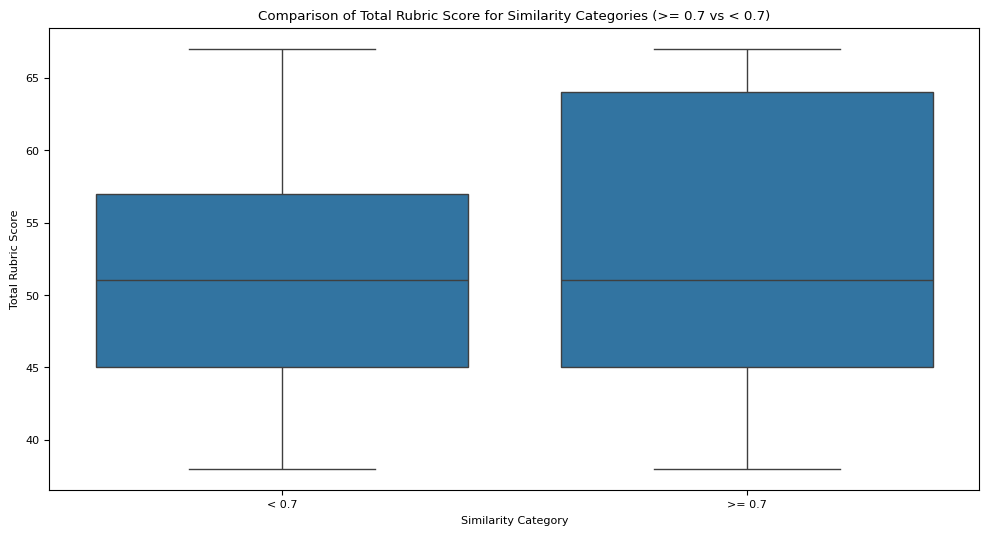


Full Correlation Matrix:

                                          Score  Total Rubric Score  Application/System Description or DFD  Application Type  Industry Sector  Data Sensitivity  Internet Facing  Compliance Requirements  Authentication Methods  Technical Details  Threat Details  Threat Count
Score                                  1.000000            0.006787                              -0.055503         -0.110803        -0.008403         -0.051699        -0.110803                 0.036070               -0.062650          -0.115046        0.024244      0.050639
Total Rubric Score                     0.006787            1.000000                               0.370951          0.373501         0.295815          0.481470         0.373501                 0.156071                0.391596          -0.088419        0.503768      0.885368
Application/System Description or DFD -0.055503            0.370951                               1.000000         -0.060511         0.310745       

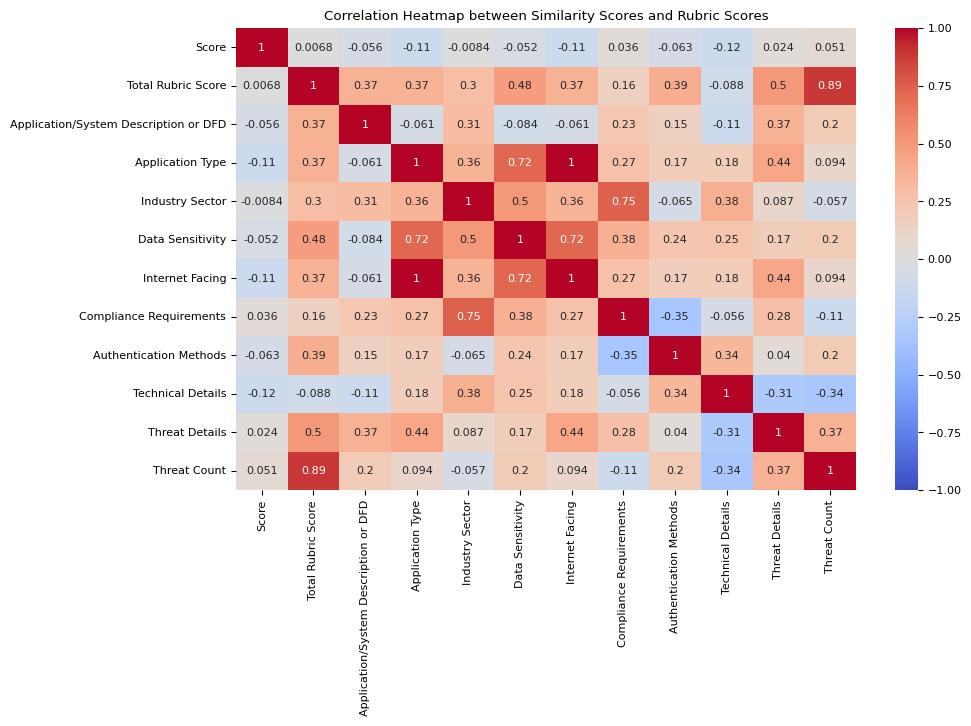

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the matching threat types DataFrame for analysis
similarity_df = matching_threat_types_df  # Assuming this is already defined
rubric_df = rubric_df  # Assuming this is already defined

# Convert 'Case Number' to int for both dataframes to match them on this column so we can sort
similarity_df['Case Number'] = similarity_df['Case Number'].astype(int)
rubric_df['Case Study Number'] = rubric_df['Case Study Number'].astype(int)

# Merge the rubric scores with the similarity data on 'Case Number'
merged_df = pd.merge(similarity_df, rubric_df, left_on='Case Number', right_on='Case Study Number', how='inner')

# Sum up the rubric points and add it as a new column
rubric_columns = [
    'Application/System Description or DFD', 'Application Type', 'Industry Sector',
    'Data Sensitivity', 'Internet Facing', 'Compliance Requirements', 'Authentication Methods',
    'Technical Details', 'Threat Details', 'Threat Count'
]
merged_df['Total Rubric Score'] = merged_df[rubric_columns].sum(axis=1)

# Create a new column to categorize similarity scores into two groups: >= 0.7 and < 0.7
merged_df['Similarity Category'] = merged_df['Score'].apply(lambda x: '>= 0.7' if x >= 0.7 else '< 0.7')

# Drop any unnecessary columns for clarity
columns_to_drop = ['Tool Threat Scenario', 'Case Threat']  # Dropping based on the actual column names
merged_df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Display the first few rows to verify the merge for sanity purposes
print("Merged DataFrame Preview:")
print(merged_df.head())

# --- Analyze the rubric scores across the two similarity categories ---

# Plot a boxplot to compare total rubric scores across the two similarity categories
plt.figure(figsize=(12, 6))
sns.boxplot(x='Similarity Category', y='Total Rubric Score', data=merged_df)
plt.title('Comparison of Total Rubric Score for Similarity Categories (>= 0.7 vs < 0.7)')
plt.ylabel('Total Rubric Score')
plt.xlabel('Similarity Category')
plt.show()

# --- Correlation Analysis ---
# Calculate the correlation between similarity scores and rubric columns including the total rubric score
correlation_df = merged_df[['Score', 'Total Rubric Score'] + rubric_columns].corr()

# Print the full correlation matrix
print("\nFull Correlation Matrix:\n")
print(correlation_df)

# Print only the correlation between Similarity Scores and Rubric Scores
print("\nCorrelation between Similarity Scores and Rubric Scores:\n")
print(correlation_df['Score'])

# Visualize the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap between Similarity Scores and Rubric Scores')
plt.show()


Case-Level Merged DataFrame Preview:
   Case Number     Score                                  Case Study  Case Study Number  Application/System Description or DFD  Application Type  Industry Sector  Data Sensitivity  Internet Facing  Compliance Requirements  Authentication Methods  Technical Details  Threat Details  Threat Count  Total Rubric Score
0            1  0.564804                    Voice-Based Applications                  1                                      5                 3                3                 3                4                        1                       1                  1               3            16                  40
1            2  0.541473                      Visual Sensor Networks                  2                                      1                 5                3                 5                5                        1                       1                  2               3            12                  38
2            3  0.

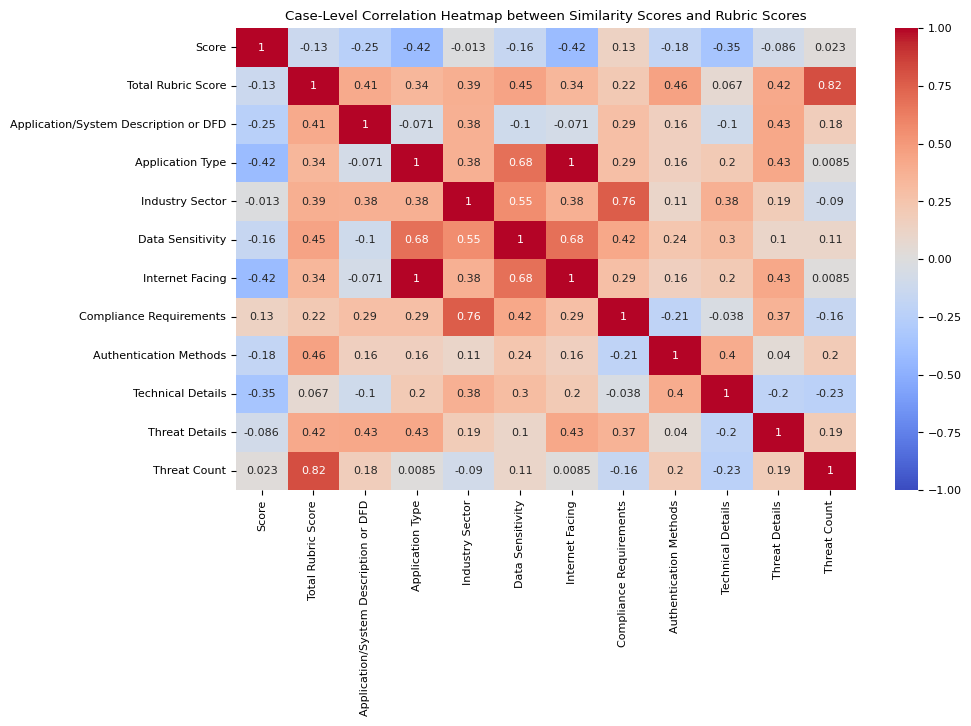

In [19]:
# Aggregate similarity scores at the case level by averaging them
case_level_similarity = similarity_df.groupby('Case Number', as_index=False)['Score'].mean()

# Merge the aggregated similarity scores with the rubric data on 'Case Number'
case_level_merged_df = pd.merge(case_level_similarity, rubric_df, left_on='Case Number', right_on='Case Study Number', how='inner')

# Sum up the rubric points and add it as a new column
case_level_merged_df['Total Rubric Score'] = case_level_merged_df[rubric_columns].sum(axis=1)

# Drop any unnecessary columns for clarity
columns_to_drop_case_level = ['Tool Threat Scenario', 'Case Threat']  # Adjust based on actual column names if needed
case_level_merged_df.drop(columns=[col for col in columns_to_drop_case_level if col in case_level_merged_df.columns], inplace=True)

# Display the first few rows to verify the merge for sanity purposes
print("Case-Level Merged DataFrame Preview:")
print(case_level_merged_df.head())

# --- Correlation Analysis at Case Level ---
# Calculate the correlation between case-level similarity scores and rubric columns including the total rubric score
case_level_correlation_df = case_level_merged_df[['Score', 'Total Rubric Score'] + rubric_columns].corr()

# Print the full correlation matrix
print("\nCase-Level Full Correlation Matrix:\n")
print(case_level_correlation_df)

# Print only the correlation between Case-Level Similarity Scores and Rubric Scores
print("\nCase-Level Correlation between Similarity Scores and Rubric Scores:\n")
print(case_level_correlation_df['Score'])

# Visualize the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(case_level_correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Case-Level Correlation Heatmap between Similarity Scores and Rubric Scores')
plt.show()


In [20]:
# Make sure this looks like the rubric file I created.  Had some caching issues
rubric_df.describe()

,Case Study Number,Application/System Description or DFD,Application Type,Industry Sector,Data Sensitivity,Internet Facing,Compliance Requirements,Authentication Methods,Technical Details,Threat Details,Threat Count
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,8.000000,4.733333,4.866667,4.333333,4.733333,4.933333,2.466667,2.066667,1.666667,4.200000,16.200000
std,4.472136,1.032796,0.516398,0.975900,0.703732,0.258199,1.407463,1.830951,0.899735,0.774597,6.526868
min,1.000000,1.000000,3.000000,3.000000,3.000000,4.000000,1.000000,1.000000,1.000000,3.000000,10.000000
25%,4.500000,5.000000,5.000000,3.000000,5.000000,5.000000,1.000000,1.000000,1.000000,4.000000,12.500000
50%,8.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,1.000000,1.000000,4.000000,13.000000
75%,11.500000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,2.500000,5.000000,18.000000
max,15.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,5.000000,32.000000


In [21]:
# Group by 'Case Study Number' and take the top 2 scores for each case study
#top_scores_df = similarity_comparison_df.groupby('Case Study Number').apply(
#    lambda x: x.nlargest(2, 'Score')
#).reset_index(drop=True)

# Select and order columns for the output
#top_scores_df = top_scores_df[[
#    'Case Study Number', 'Tool Threat Type', 'Tool Threat Scenario', 'Case Threat', 'Score'
#]]

# Rename the columns to match the format for the table in MS Word
#top_scores_df.columns = [
#    'Case Study', 'Threat Type', 'Tool-Generated Threat', 'Expert-Generated Threat', 'Cosine Similarity Score'
#]

# Display the DataFrame
#print(top_scores_df.head())

# Save the top 2 similarity scores to a tab-delimited file
#top_scores_df.to_csv('top_similarity_scores.tsv', sep='\t', index=False)

#print("\nTop 2 Similarity Scores per Case Study saved to 'top_similarity_scores.tsv'.")


# Hypothesis 3

## Run Match Categorization
A generative AI-enhanced threat modeling tool can systematically map STRIDE-categorized threats to relevant MITRE ATT&CK Tactics, Techniques, and Procedures (TTPs), ensuring comprehensive alignment with established cybersecurity frameworks.

---

What are we covering?
- Checking to see if a MITRE ATT&CK TTP can be mapped to a threat the tool generated
- an unmapped threat has an attack pattern of

```
attack-pattern--00000000-0000-0000-0000-000000000000
```
- The goal is to map 80% of threats to a MITRE ATT&CK TTP




In [22]:
# Define the pattern for unmapped MITRE techniques
UNMAPPED_ID = "attack-pattern--00000000-0000-0000-0000-000000000000"

# Create a new column that checks whether each threat is mapped to a valid MITRE TTP
# This will be True if neither MITRE PA-ID is equal to the unmapped ID nor MITRE TID is 'N/A'
tool_results_df['Mapped to MITRE TTP'] = (tool_results_df['MITRE PA-ID'] != UNMAPPED_ID) & (tool_results_df['MITRE TID'] != "N/A")

# Optional: Show a preview of the updated DataFrame
print(tool_results_df.head())

# Calculate the total number of threats and the number of mapped threats
total_threats = len(tool_results_df)
mapped_threats = tool_results_df['Mapped to MITRE TTP'].sum()

# Calculate the percentage of threats mapped to MITRE TTPs
success_rate = (mapped_threats / total_threats) * 100

# Output the results
print(f"Total STRIDE Threats: {total_threats}")
print(f"Mapped to MITRE ATT&CK TTPs: {mapped_threats}")
print(f"Success Rate: {success_rate:.2f}%")

# Optional: Save the updated DataFrame to a CSV for further analysis
tool_results_df.to_csv('mapped_threats_with_threat_type.csv', index=False)


  Case Study Number Batch Number Threat Type                                                                                                                          Scenario                                                                                           Potential Impact MITRE Technique                                           MITRE PA-ID MITRE TID  Scenario Word Count  Mapped to MITRE TTP
0                 1            1    Spoofing                                                       An attacker uses voice imitation software to impersonate a legitimate user.  Unauthorized access to the system, which can lead to information disclosure and control over IoT devices.         Unknown  attack-pattern--00000000-0000-0000-0000-000000000000       N/A                   11                False
1                 1            1    Spoofing                                   An attacker gains access to the client-side application by hijacking the network communication.                  

## Results

**Hypothesis**: *A generative AI-enhanced threat modeling tool can systematically map STRIDE-categorized threats to relevant MITRE ATT&CK Tactics, Techniques, and Procedures (TTPs), ensuring comprehensive alignment with established cybersecurity frameworks.*

#### **Key Results**:
- **Total Threats Analyzed**: 8100
- **Mapped Threats**: **6921 threats** (85.44%) were successfully mapped to MITRE ATT&CK TTPs.
- **Unmapped Threats**: **1179 threats** (14.56%) could not be mapped to a specific MITRE ATT&CK TTP.
- The **threshold of 80%** was set as the success criterion, and the tool **exceeded this threshold** by successfully mapping **85.44%** of threats to valid MITRE TTPs.

These results indicate that the generative AI-enhanced tool demonstrates strong alignment with MITRE ATT&CK TTPs, exceeding the predefined success threshold of 80%, thus confirming its capability to comprehensively map STRIDE threats to established cybersecurity frameworks.

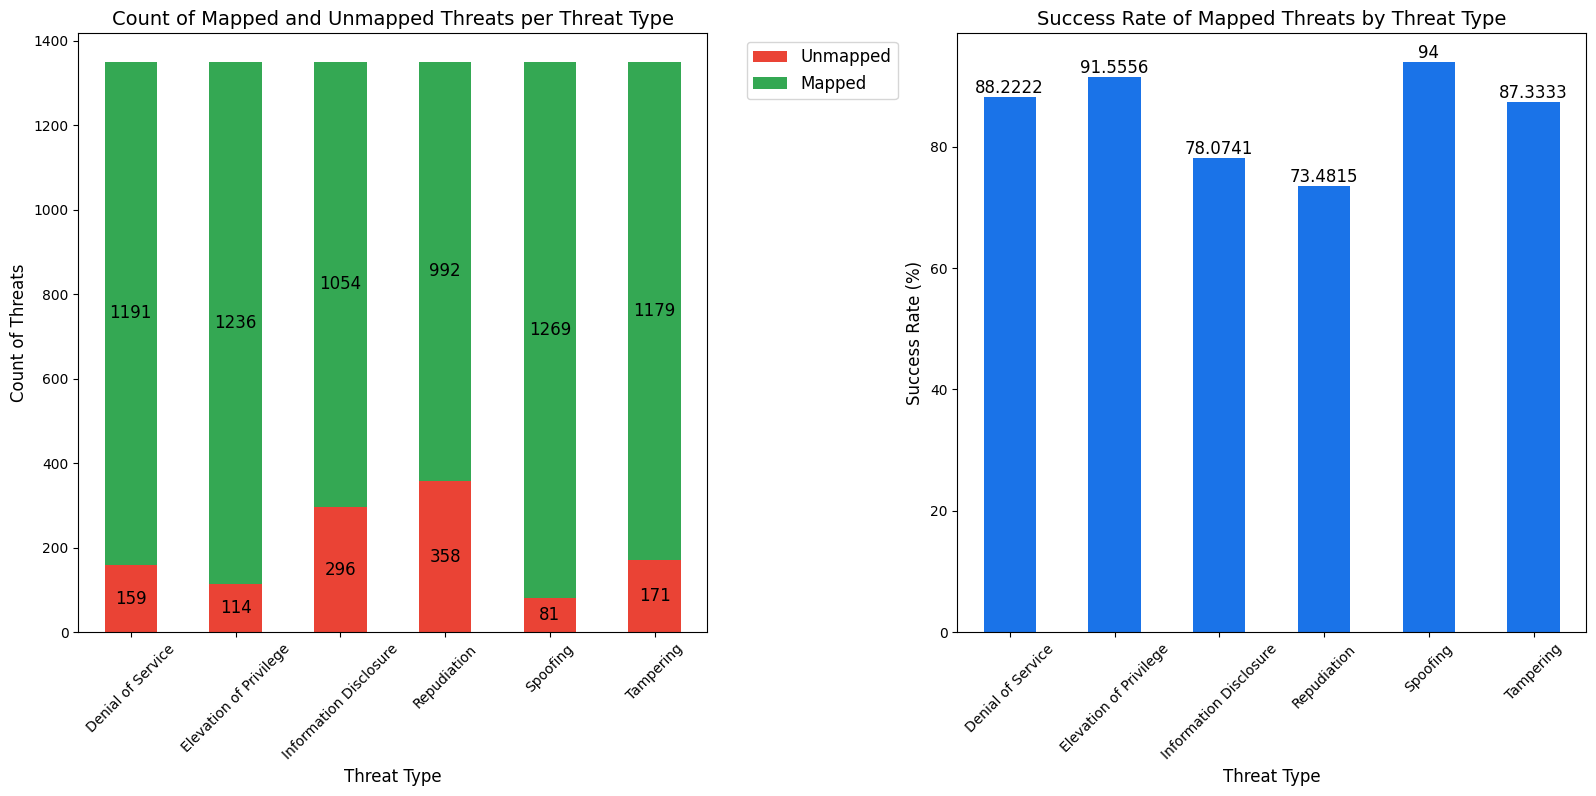

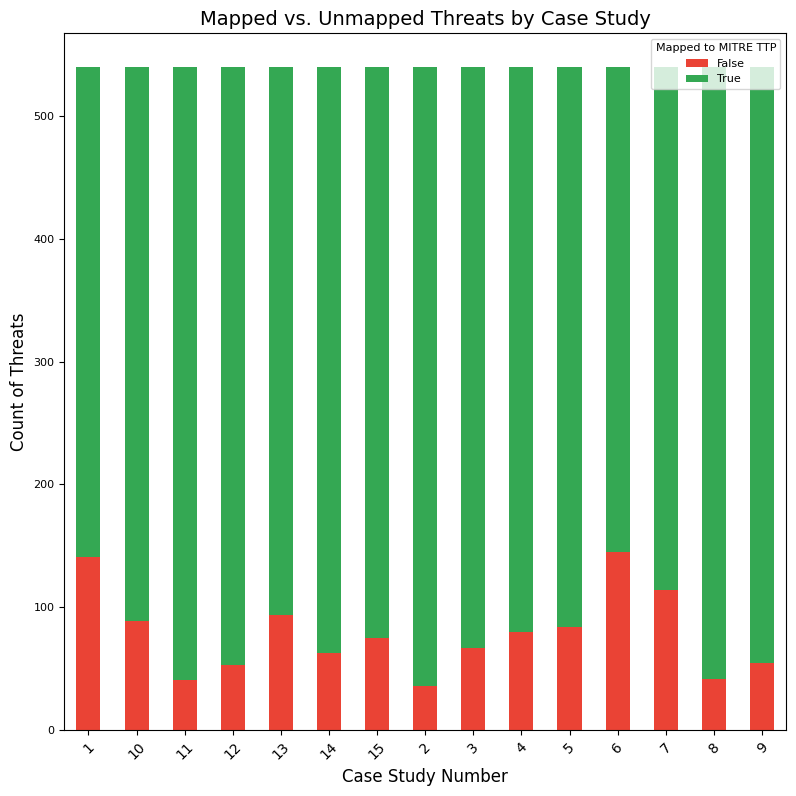

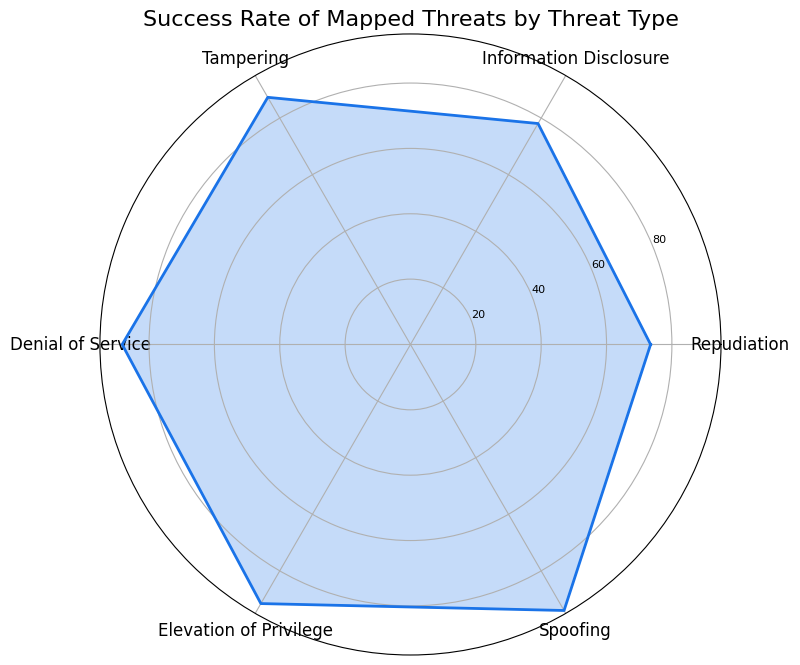

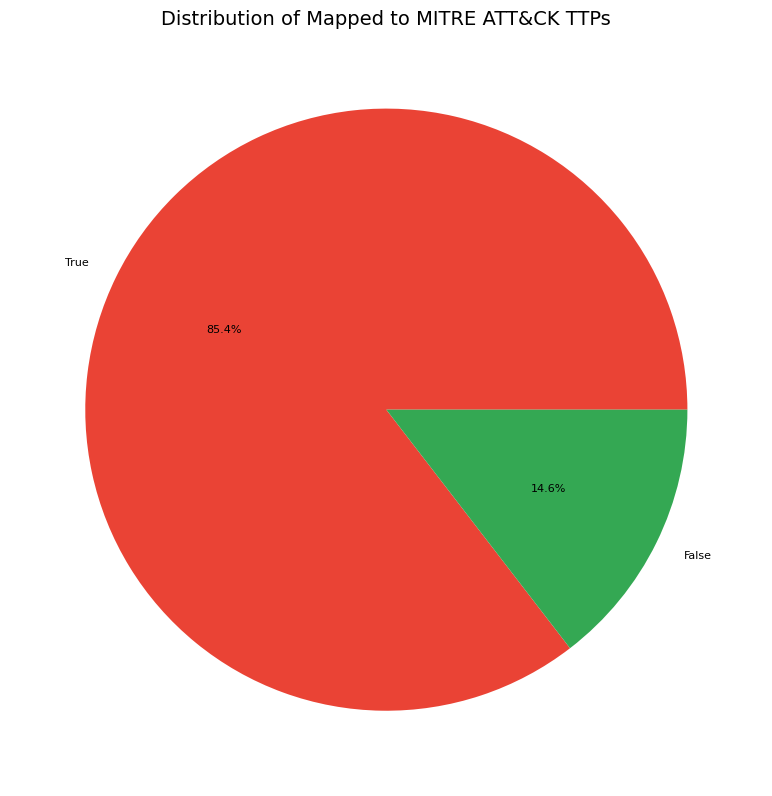

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the data for both plots by 'Threat Type'
df_grouped_mapped = tool_results_df.groupby(['Threat Type', 'Mapped to MITRE TTP']).size().unstack(fill_value=0)
df_grouped_mapped = df_grouped_mapped.sort_index()  # Ensure consistent order

# Get the sorted list of threat types for use in both plots
sorted_threat_types = df_grouped_mapped.index

# Create figure for the two "by Threat Type" graphs
fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Adjusted figure size for two bar charts

# --- Plot 1: Count of Mapped and Unmapped Threats per Threat Type ---
ax1 = df_grouped_mapped.plot(kind='bar', stacked=True, ax=axes[0], color=['#ea4335', '#34a853'])

# Annotate the bars with their values
for container in ax1.containers:
    ax1.bar_label(container, label_type='center', fontsize=12)

ax1.set_title('Count of Mapped and Unmapped Threats per Threat Type', fontsize=14)
ax1.set_xlabel('Threat Type', fontsize=12)
ax1.set_ylabel('Count of Threats', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)
ax1.tick_params(axis='y', labelsize=10)

# Adjust legend position to outside of the plot
ax1.legend(['Unmapped', 'Mapped'], fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# --- Plot 3: Success Rate of Mapped Threats by Threat Type ---
df_grouped = tool_results_df.groupby('Threat Type')['Mapped to MITRE TTP'].mean() * 100
df_grouped = df_grouped.loc[sorted_threat_types]  # Ensure same order as in the first plot

ax3 = df_grouped.plot(kind='bar', color='#1a73e8', ax=axes[1])

# Annotate the bars with their values
for container in ax3.containers:
    ax3.bar_label(container, label_type='edge', fontsize=12)

ax3.set_title('Success Rate of Mapped Threats by Threat Type', fontsize=14)
ax3.set_xlabel('Threat Type', fontsize=12)
ax3.set_ylabel('Success Rate (%)', fontsize=12)
ax3.tick_params(axis='x', rotation=45, labelsize=10)
ax3.tick_params(axis='y', labelsize=10)

# Save the "Threat Type" graphs as an image
plt.tight_layout()
plt.savefig('threat_type_charts.png')
plt.show()




# Create figure for the "Case Study" graph
fig, ax4 = plt.subplots(figsize=(8, 8))  # Adjusted figure size for one bar chart

# --- Plot 4: Mapped vs. Unmapped Threats by Case Study ---
df_grouped_case = tool_results_df.groupby(['Case Study Number', 'Mapped to MITRE TTP']).size().unstack(fill_value=0)
df_grouped_case = df_grouped_case.sort_index()

ax4 = df_grouped_case.plot(kind='bar', stacked=True, ax=ax4, color=['#ea4335', '#34a853'])
ax4.set_title('Mapped vs. Unmapped Threats by Case Study', fontsize=14)
ax4.set_xlabel('Case Study Number', fontsize=12)
ax4.set_ylabel('Count of Threats', fontsize=12)
ax4.tick_params(axis='x', rotation=45, labelsize=10)

# Save the "Case Study" graph as an image
plt.tight_layout()
plt.savefig('case_study_chart.png')
plt.show()




import matplotlib.pyplot as plt
import numpy as np

# --- Plot 5: Success Rate by Threat Type (Radar Chart) ---
# Calculate success rate (percentage of mapped threats) by Threat Type
threat_success_rate = tool_results_df.groupby('Threat Type')['Mapped to MITRE TTP'].mean() * 100
threat_success_rate = threat_success_rate.sort_values()

# Get the threat type names for labels
threat_type_labels = threat_success_rate.index.tolist()

# Number of distinct threat types
num_vars = len(threat_success_rate)

# Compute angle for each threat type on the radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
threat_success_rate = threat_success_rate.tolist()
threat_success_rate += threat_success_rate[:1]

# Create radar chart
fig, ax5 = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))  # New figure for radar chart
ax5.fill(angles, threat_success_rate, color='#1a73e8', alpha=0.25)
ax5.plot(angles, threat_success_rate, color='#1a73e8', linewidth=2)

# Set the labels for each threat type
ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(threat_type_labels, fontsize=12)

# Add a title
ax5.set_title('Success Rate of Mapped Threats by Threat Type', size=16)

# Save radar chart as an image
plt.tight_layout()
plt.savefig('radar_chart.png')
plt.show()
# --- Plot 2: Distribution of Mapped to MITRE ATT&CK TTPs ---
fig, ax = plt.subplots(figsize=(8, 8))  # New figure for pie chart
tool_results_df['Mapped to MITRE TTP'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                                          colors=['#ea4335', '#34a853'], ax=ax)

ax.set_title('Distribution of Mapped to MITRE ATT&CK TTPs', fontsize=14)
ax.set_ylabel('')  # Hide the y-label for better visualization

# Save pie chart as an image
plt.tight_layout()
plt.savefig('pie_chart.png')
plt.show()


# Kill the Runtime
Reduce costs and credits

In [24]:
# Save yourself some $$

#from google.colab import runtime
#runtime.unassign()